# Figure generation for "Length Biases in Single-Cell RNA Sequencing of pre-mRNA"

This notebook generates all figures in the body and supplement of "Length Biases in Single-Cell RNA Sequencing of pre-mRNA" based on pre-computed results from *Monod*.

The notebook is fairly large, and generates some sixty figures. We have attempted to make it fairly modular. The "Prerequisites" section is required by every figure, but we do not need to go down the line and run every single cell: we can typically start at the relevant heading.

The analyses and visualizations largely reproduce the functionality in the *Monod* Python package, and heavily use its functions. All of the notebooks used *Monod* 0.2.5.0 to generate and analyze the data. For the convenience, we rewrite some of its functionality in the current notebook, so aesthetics can be modified simply by changing entries in the `aesthetics` dictionary.

## Prerequisites

Load in *Monod* and other prerequisites.

In [1]:
import sys
sys.path.insert(0, '/home/ggorin/projects/monod/src/')

In [2]:
import monod
from monod import preprocess, extract_data, cme_toolbox, inference, analysis

In [141]:
import pandas as pd
import numpy as np
import loompy as lp
import matplotlib
import matplotlib.pyplot as plt
import scipy

Define metadata for the `kb` runs.

In [11]:
spliced_layer = 'spliced'
unspliced_layer = 'unspliced'
gene_attr = 'gene_name'
cell_attr = 'barcode'

attribute_names=[(unspliced_layer,spliced_layer),gene_attr,cell_attr]

Define gene length reference locations with.

In [19]:
dict_locations = ['../polyA_ref/' + x for x in ['gg_200525_genome_polyA_cum_3','gg_200524_mouse_genome_polyA_cum_1']]
transcriptome_dicts = [monod.preprocess.get_transcriptome(x) for x in dict_locations] #human then mouse

Define all aesthetics.

In [1645]:
from matplotlib.colors import ListedColormap

c1 = [173/255,214/255,200/255]
c2 = [59/255,131/255,130/255]
ncol=50
cmap_histogram = ListedColormap(np.array([np.linspace(c2[j],c1[j],ncol) for j in range(3)]).T)

c1 = [0,0,0,0]
# c2 = [1,1,1,1]
c2 = [235/255,228/255,143/255,1]
ncol=2
cmap_highlight_landscape = ListedColormap(np.array([np.linspace(c2[j],c1[j],ncol) for j in range(4)]).T)


aesthetics = \
    {'selected_markersize_body':2.2,'omitted_markersize_body':1.8,
     'selected_markersize_supp':2.2,'selected_markersize_supp':1.8,
     'selected_color':np.array([212,107,75])/255,
     'omitted_color':'lightgray',
     'selected_alpha':0.3,'omitted_alpha':0.1,'fontsize_body_axes':14,'fontsize_body_title':16,
     'pmf_colormap':cmap_histogram,
     'landscape_colormap':cmap_histogram,
     'landscape_highlight_colormap':cmap_highlight_landscape,
     'optimum_color':[212/255,107/255,75/255],
     'optimum_markersize':100,
     'highlighted_optimum_markersize':300,
     'dataset_colors':('violet','darkorchid','rebeccapurple','midnightblue'),
     "accepted_gene_color": [203/255,197/255,149/255],
     "rejected_gene_color": "darkgrey",
     "accepted_gene_alpha": 0.4,
     "rejected_gene_alpha": 0.5,
     "accepted_gene_ms": 5,
     "rejected_gene_ms": 5,
     'hist_face_color':'lightgray',
     "hist_fit_color":  [59/255,131/255,130/255],
     "hist_fit_lw": 3,
     'identity_line_color':[212/255,107/255,75/255],
     'identity_lw':3,
     'v2_gene_color':[39/255]*3,
     'celltype_diffs_gene_color':[39/255]*3,
     'celltype_colors_pbmc':('orange','teal','mediumvioletred'),
     'celltype_colors_allen':('lightcoral','lightseagreen'),
     'celltype_marker_alpha':0.8,
     'celltype_diffs_gene_alpha':0.3,
     'celltype_diffs_ms':4,
     'celltype_marker_ms':60,
     'partition_line_color':'lightcoral',
}

Define figure output directory.

In [78]:
figdir = './figs'

Define the whole-dataset analyses: the *Monod* batches as well as the datasets analyzed in each batch.

This involves defining "replicate pairs," i.e., sets of samples that are mutual biological or technical replicates.

In [755]:
batch_dirs = ['gg_221118_025_pbmc_1','gg_221115_025_heart_1','gg_221116_025_neuron_1','gg_221118_025_allen_1']
 
dataset_v3_list = [['pbmc_1k_v3','pbmc_10k_v3'],
                     ['heart_1k_v3','heart_10k_v3'],
                     ['neuron_1k_v3','neuron_10k_v3'],
                     ['allen_'+x for x in ['B08','C01','F08','H12','B01','A01']]]
dataset_v2_list = ['pbmc_1k_v2','heart_1k_v2','neuron_1k_v2','allen_B05']

dataset_name_list = [['pbmc_1k_v2','pbmc_1k_v3','pbmc_10k_v3'],
                     ['heart_1k_v2','heart_1k_v3','heart_10k_v3'],
                     ['neuron_1k_v2','neuron_1k_v3','neuron_10k_v3'],
                     ['allen_'+x for x in ['B05','B08','C01','F08','H12','B01','A01']]]

tenX_dir = '/home/ggorin/count_data/loom_10x_kb/'
allen_dir = '/home/ggorin/count_data/loom_allen_kb/'
raw_looms = [[tenX_dir+x+'.loom' for x in dataset_name_list[0]], \
            [tenX_dir+x+'.loom' for x in dataset_name_list[1]], \
            [tenX_dir+x+'.loom' for x in dataset_name_list[2]], \
            [allen_dir+x+'_raw.loom' for x in dataset_name_list[3]]]

batch_names = ['pbmc','heart','neuron','allen']
tech_replicate_pairs = [[[0,1]],[[0,1]],[[0,1]],[[1,4],[3,5]]]
bio_replicate_pairs = [[],[],[],[[0,1],[1,2],[2,3],[0,2],[0,3]]]
tech_v2_replicate_pairs = [[0,2],[0,2],[0,2],[0,5]]

Define batches for the analysis without a technical noise model.

In [1125]:
batch_dirs_noisefree =  ['gg_221119_025_pbmc_noisefree_1',\
                         'gg_221119_025_heart_noisefree_1',\
                         'gg_221119_025_neuron_noisefree_1',\
                         'gg_221119_025_allen_noisefree_1']

Define batch metadata and marker genes for the PBMC cell type comparison.

In [1198]:
pbmc_celltype_dataset = dataset_v3_list[0][1]
pbmc_baseline_dir = batch_dirs[0]
pbmc_celltype_batch_dir = 'gg_221118_025_pbmc_celltypes_1'
pbmc_celltype_names = ['Tcells','Monocytes','Bcells']
pbmc_celltype_names_labels = ['T cells','monocytes','B cells']
pbmc_celltypes = [pbmc_celltype_dataset + '_' + x for x in pbmc_celltype_names]
pbmc_markers = [['CD3D', 'CD3G','CD3E','CD247','CD2','TCF7','CD4','CD69','CCL5'],
      ['CD93','CSTA','FPR1','CD14','CD36'],
      ['CD79A','CD22','BLK','IGHD','VPREB3']]


Define batch metadata and marker genes for the Allen cell type comparison.

In [1347]:
allen_celltype_datasets = dataset_v3_list[3][:4]
allen_celltype_batch_dir = 'gg_221119_025_allen_celltypes_1'
allen_celltype_names = ['Glutamatergic','GABAergic']
allen_celltype_names_labels = ['glutamatergic','GABAergic']
allen_celltypes = [[dataset + '_' + celltype for celltype in allen_celltype_names] for dataset in allen_celltype_datasets]
allen_markers = [['Slc17a7','Slc17a6'],
      ['Gad1', 'Gad2', 'Slc32a1','Slc6a5']]

Define batch metadata for the method of moments initialization benchmark.

In [1700]:
MoM_batch_dir = 'gg_221120_025_pbmc_MoM_1'
MoM_dataset = dataset_v3_list[0][0]
MoM_trials = ['Bursty_Poisson_10x11_10rest','Bursty_Poisson_10x11_1rest']

Define batch metadata for the control with a length-independent technical noise model.

In [1731]:
nolength_batch_dir = 'gg_221120_025_pbmc_nolengths_1'
nolength_dataset = dataset_v3_list[0][0]

In [1132]:
param_names = ['Burst size','Splicing rate','Degradation rate']

## Fig. 1: the naive noise-free model

In [902]:
def plot_spliced_unspliced_means(dataset_names,transcriptomes,gene_lists,filename,figsize=(12,6)):
    fig1, ax1 = plt.subplots(nrows=2,ncols=len(dataset_names),figsize=figsize)

    for k in range(len(dataset_names)):
        loom_filepath = loom_filepaths[k]
        dataset_name = dataset_names[k]
        feat_dict = transcriptomes[k]


        layers,gene_names,nCells = monod.preprocess.import_vlm(loom_filepath,attribute_names)

        U_mean = layers[0].mean(1)
        S_mean = layers[1].mean(1)

        ann_filt = monod.preprocess.identify_annotated_genes(gene_names,feat_dict)
        U_mean,S_mean,gene_names = monod.preprocess.filter_by_gene(ann_filt,U_mean,S_mean,gene_names)
        len_arr = np.asarray([feat_dict[x] for x in gene_names])



        ax1[0,k].set_title(dataset_name,fontsize=aesthetics['fontsize_body_title'])

        gf = np.isin(gene_names,gene_lists[k])

        ax1[0,k].scatter(len_arr[~gf],S_mean[~gf],s=aesthetics['omitted_markersize_body'],c=aesthetics['omitted_color'],
                        alpha=aesthetics['omitted_alpha'])
        ax1[0,k].scatter(len_arr[gf],S_mean[gf],s=aesthetics['selected_markersize_body'],c=aesthetics['selected_color'],
                        alpha=aesthetics['selected_alpha'])

        ax1[1,k].scatter(len_arr[~gf],U_mean[~gf],s=aesthetics['omitted_markersize_body'],c=aesthetics['omitted_color'],
                        alpha=aesthetics['omitted_alpha'])
        ax1[1,k].scatter(len_arr[gf],U_mean[gf],s=aesthetics['selected_markersize_body'],c=aesthetics['selected_color'],
                        alpha=aesthetics['selected_alpha'])

        ax1[0,k].set_xscale('log')
        ax1[0,k].set_yscale('log')
        ax1[1,k].set_xscale('log')
        ax1[1,k].set_yscale('log')
        if k==0:
            ax1[0,k].set_ylabel(r'Mean spliced',fontsize=aesthetics['fontsize_body_axes'])
            ax1[1,k].set_ylabel(r'Mean unspliced',fontsize=aesthetics['fontsize_body_axes'])
        ax1[1,k].set_xlabel(r'Gene length',fontsize=aesthetics['fontsize_body_axes'])

    fig1.tight_layout()
    fig1.savefig(figdir+'/'+filename+'.png',dpi=600)


### Panel a: trends in gene length and mean counts

In Fig. 1a, we show that a wide variety of 10x datasets shows a counterintuitive length bias in count statistics: different genes have fairly comparable amounts of spliced RNA, but unspliced RNA are overrepresented for long genes. Orange denotes genes selected for further analysis by *Monod*.

In [903]:
dataset_names = ['pbmc_1k_v3','heart_1k_v3','neuron_1k_v3']
loom_filepaths = ['/home/ggorin/count_data/loom_10x_kb/'+x+'.loom' for x in dataset_names]
transcriptomes = [transcriptome_dicts[0]] + [transcriptome_dicts[1]]*2

In [904]:
gene_list_filepaths = ['./fits/'+x+'/genes.csv' for x in batch_dirs[:3]]
gene_lists = [list(pd.read_csv(x,header=None).iloc[0]) for x in gene_list_filepaths]

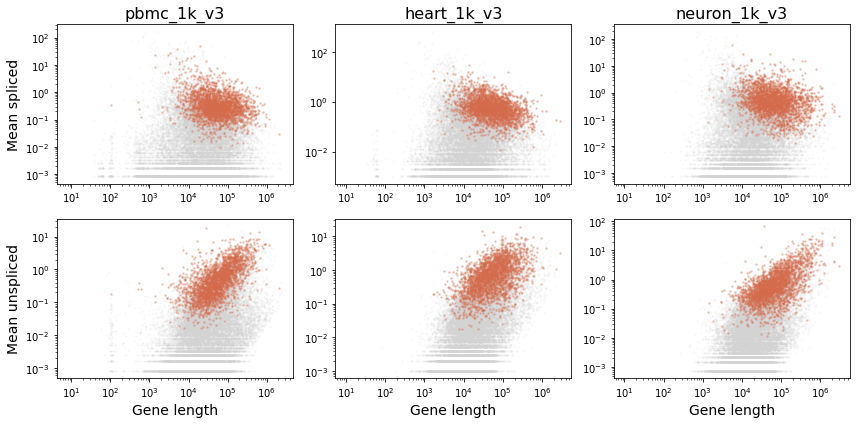

In [905]:
plot_spliced_unspliced_means(dataset_names,transcriptomes,gene_lists,'expression_bias_subset')

### Supplements to 1a

#### PBMC

In [906]:
dataset_names = dataset_name_list[0]
# dataset_names = ['pbmc_1k_v2','pbmc_1k_v3','pbmc_10k_v3']
loom_filepaths = ['/home/ggorin/count_data/loom_10x_kb/'+x+'.loom' for x in dataset_names]
transcriptomes = [transcriptome_dicts[0]]*3
gene_list_filepaths = ['./fits/'+x+'/genes.csv' for x in [batch_dirs[0]]*3]
gene_lists = [list(pd.read_csv(x,header=None).iloc[0]) for x in gene_list_filepaths]

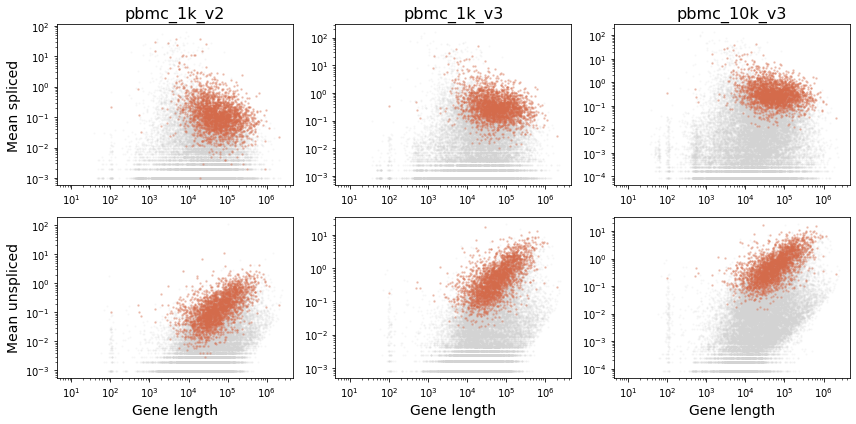

In [907]:
plot_spliced_unspliced_means(dataset_names,transcriptomes,gene_lists,'expression_bias_pbmc')

#### Heart

In [908]:
dataset_names = dataset_name_list[1]
loom_filepaths = ['/home/ggorin/count_data/loom_10x_kb/'+x+'.loom' for x in dataset_names]
transcriptomes = [transcriptome_dicts[1]]*3
gene_list_filepaths = ['./fits/'+x+'/genes.csv' for x in [batch_dirs[1]]*3]
gene_lists = [list(pd.read_csv(x,header=None).iloc[0]) for x in gene_list_filepaths]

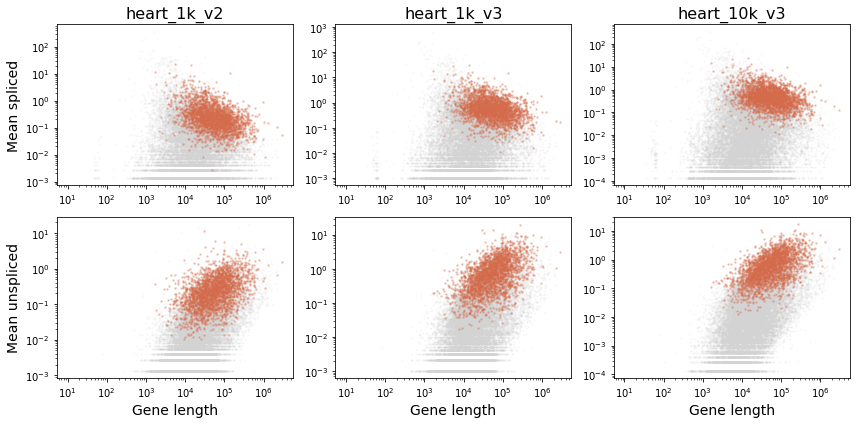

In [909]:
plot_spliced_unspliced_means(dataset_names,transcriptomes,gene_lists,'expression_bias_heart')

#### Neuron

In [910]:
dataset_names = dataset_name_list[2]
loom_filepaths = ['/home/ggorin/count_data/loom_10x_kb/'+x+'.loom' for x in dataset_names]
transcriptomes = [transcriptome_dicts[1]]*3
gene_list_filepaths = ['./fits/'+x+'/genes.csv' for x in [batch_dirs[2]]*3]
gene_lists = [list(pd.read_csv(x,header=None).iloc[0]) for x in gene_list_filepaths]

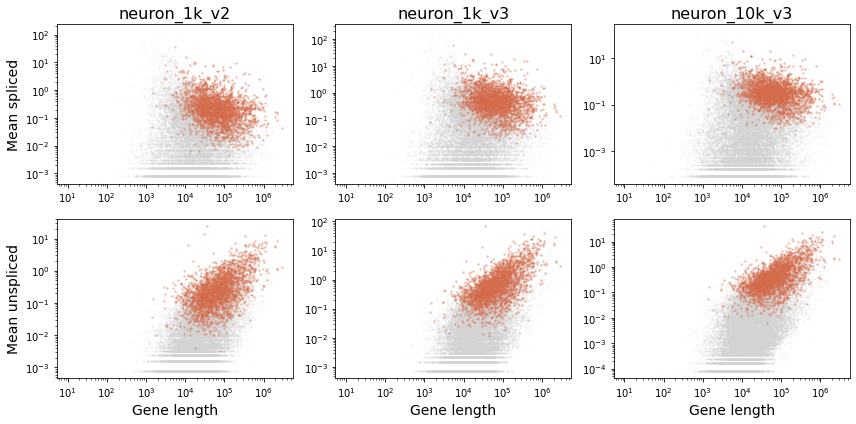

In [911]:
plot_spliced_unspliced_means(dataset_names,transcriptomes,gene_lists,'expression_bias_neuron')

#### Allen

In [912]:
dataset_names = dataset_name_list[3]
loom_filepaths = ['/home/ggorin/count_data/loom_allen_kb/'+x+'_raw.loom' for x in dataset_names]
transcriptomes = [transcriptome_dicts[1]]*7
gene_list_filepaths = ['./fits/'+x+'/genes.csv' for x in [batch_dirs[3]]*7]
gene_lists = [list(pd.read_csv(x,header=None).iloc[0]) for x in gene_list_filepaths]

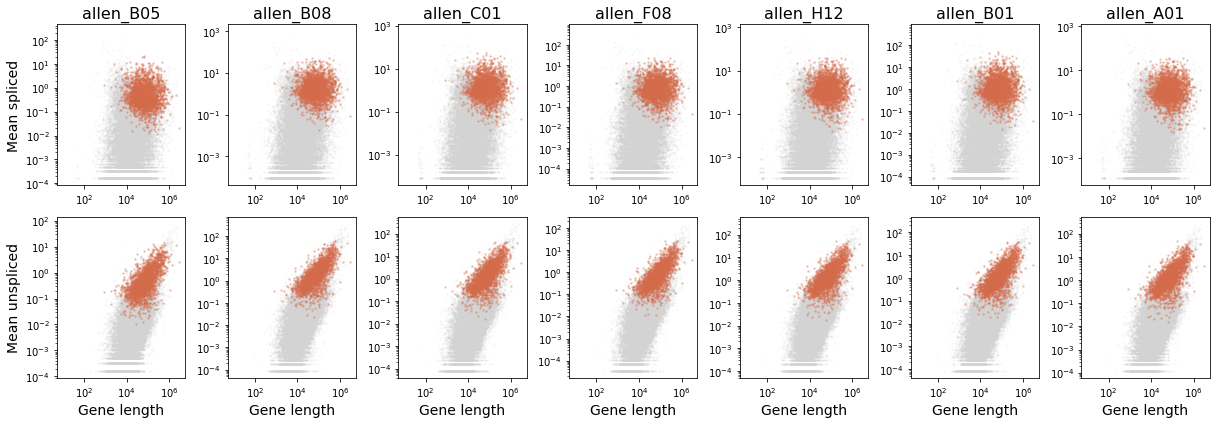

In [913]:
plot_spliced_unspliced_means(dataset_names,transcriptomes,gene_lists,'expression_bias_allen',figsize=(17,6))

### Panel b: Trends under the noise-free model

In [1168]:
def plot_param_length_dependence_noisefree(sr,ax1):
    gene_lengths = 10**sr.gene_log_lengths
    phys_params = 10**sr.phys_optimum

    c = 2.576
    err_high = 10**(sr.phys_optimum + c*sr.sigma) - phys_params
    err_low = phys_params - 10**(sr.phys_optimum - c*sr.sigma)

    gf = ~sr.rejected_genes

    for k in range(3):
        ax1[k].errorbar(gene_lengths[gf],phys_params[gf,k],yerr=[err_low[gf,k],err_high[gf,k]],
                        color=aesthetics['accepted_gene_color'],
                       alpha=aesthetics['accepted_gene_alpha'],linestyle="None",zorder=-100)
        ax1[k].scatter(gene_lengths[~gf],phys_params[~gf,k],
                        color=aesthetics['rejected_gene_color'],
                       alpha=aesthetics['rejected_gene_alpha'],s=aesthetics['rejected_gene_ms'],zorder=100)
        ax1[k].set_ylim([10**sr.sp.phys_lb[k],10**sr.sp.phys_ub[k]])

        ax1[k].set_yscale('log')
        ax1[k].set_xscale('log')


In [1443]:
def plot_and_export_param_length_dependence_noisefree(batch_index,figsize=(12,10)):
    dataset_names = dataset_name_list[batch_index]
    n_datasets = len(dataset_names)
    fig1, ax1 = plt.subplots(nrows=n_datasets,ncols=3,figsize=figsize)
    for k in range(n_datasets):
        dataset_name = dataset_names[k]
        sr = monod.analysis.load_search_results('./fits/'+batch_dirs_noisefree[batch_index]+'/'+dataset_name+'/Bursty_None_1x1/grid_scan_results_upd.res')
        plot_param_length_dependence_noisefree(sr,ax1[k])
    for k in range(n_datasets):
        ax1[k,0].set_ylabel(dataset_names[k],fontsize=aesthetics['fontsize_body_axes'])
    for k in range(n_datasets-1):
        for j in range(3):
            ax1[k,j].set_xticks([])

    for k in range(3):
        ax1[0,k].set_title(param_names[k],fontsize=aesthetics['fontsize_body_axes'])
        ax1[n_datasets-1,k].set_xlabel('Gene length',fontsize=aesthetics['fontsize_body_axes'])

    fig1.tight_layout()
    fig1.savefig('./'+figdir+'/noisefree_parameter_length_trends_'+batch_names[batch_index]+'.png',dpi=600)

In Fig. 1b, we show that these data can be fit to a simple Singh-Bokes model of bursty transcription, splicing, and degradation, but the resulting parameters show unexpected and contradictory dependence on gene length. This suggests that a technical noise model is necessary.

In [1444]:
sr = monod.analysis.load_search_results('./fits/'+batch_dirs_noisefree[0]+'/'+dataset_v3_list[0][1]+'/Bursty_None_1x1/grid_scan_results_upd.res')

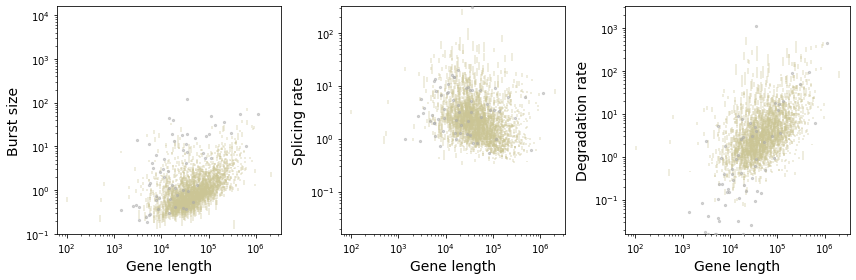

In [1445]:
fig1, ax1 = plt.subplots(nrows=1,ncols=3,figsize=(12,4))
plot_param_length_dependence_noisefree(sr,ax1[:3])
for k in range(3):
    ax1[k].set_ylabel(param_names[k],fontsize=aesthetics['fontsize_body_axes'])
    ax1[k].set_xlabel('Gene length',fontsize=aesthetics['fontsize_body_axes'])
fig1.tight_layout()
fig1.savefig('./'+figdir+'/noisefree_parameter_length_trends_subset.png',dpi=600)

### Supplements to 1b

#### PBMC

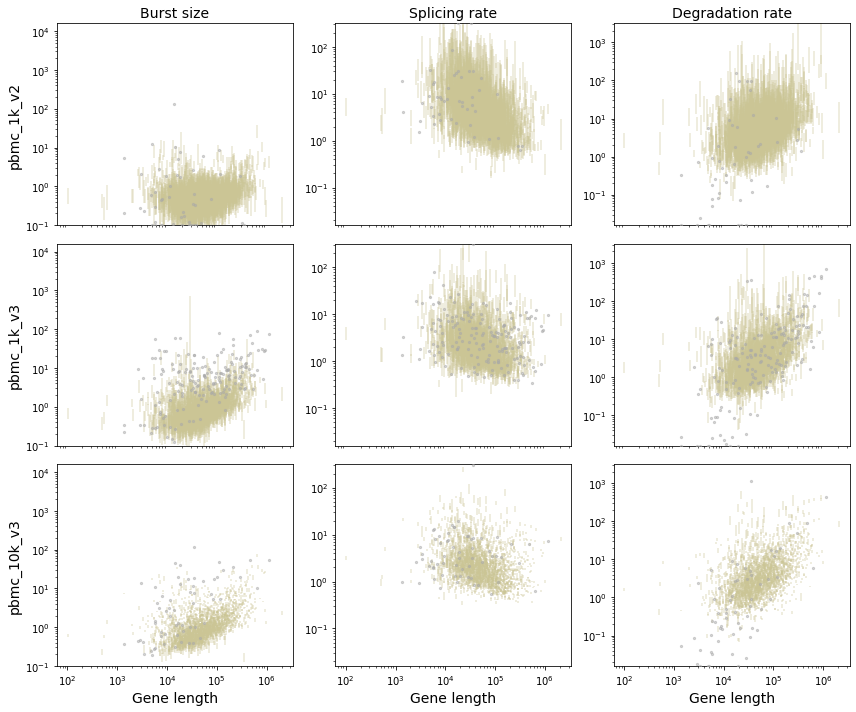

In [1446]:
plot_and_export_param_length_dependence_noisefree(0)

#### Heart

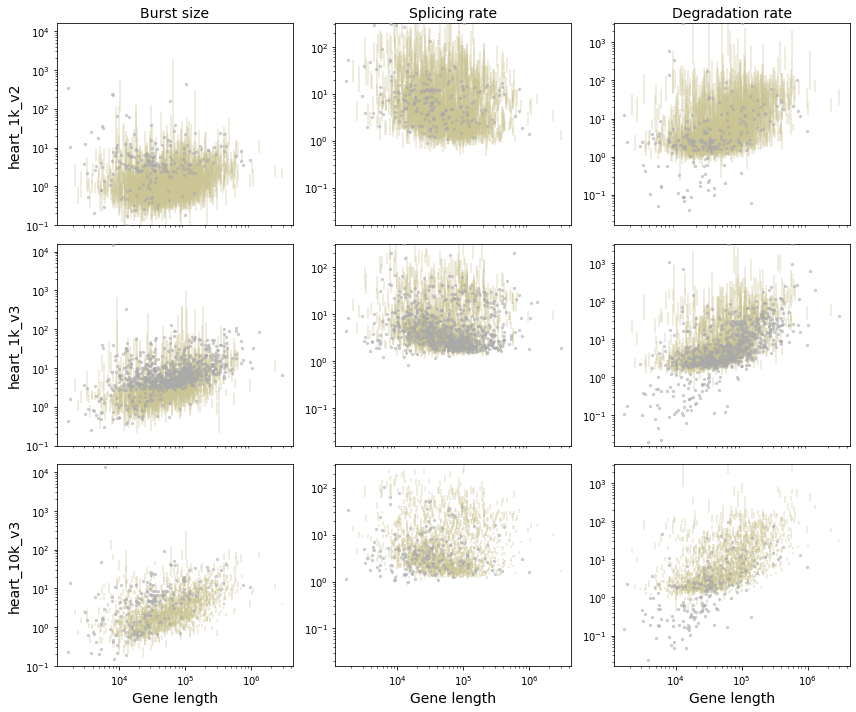

In [1447]:
plot_and_export_param_length_dependence_noisefree(1)

#### Neuron

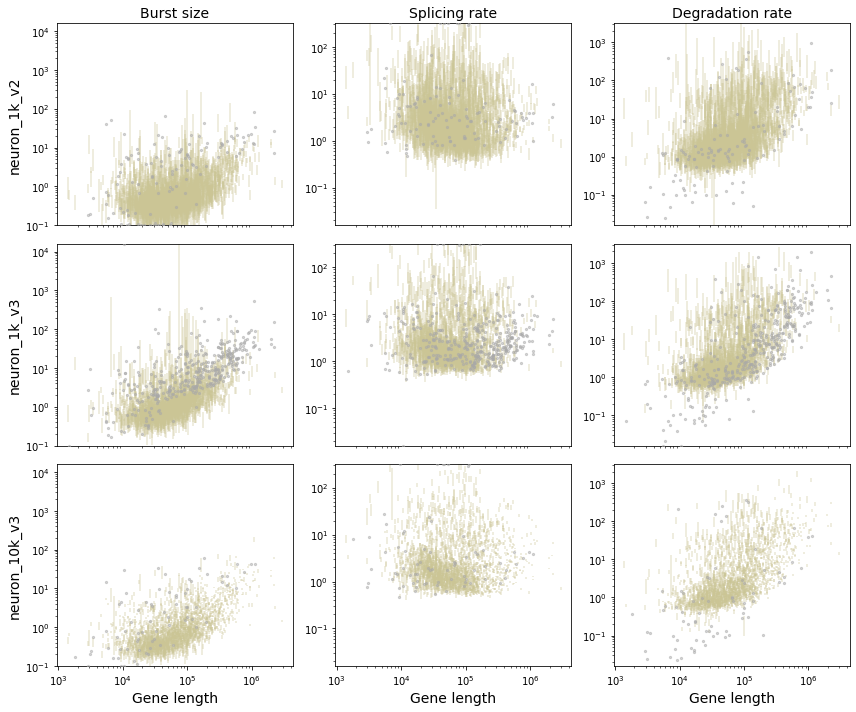

In [1448]:
plot_and_export_param_length_dependence_noisefree(2)

#### Allen

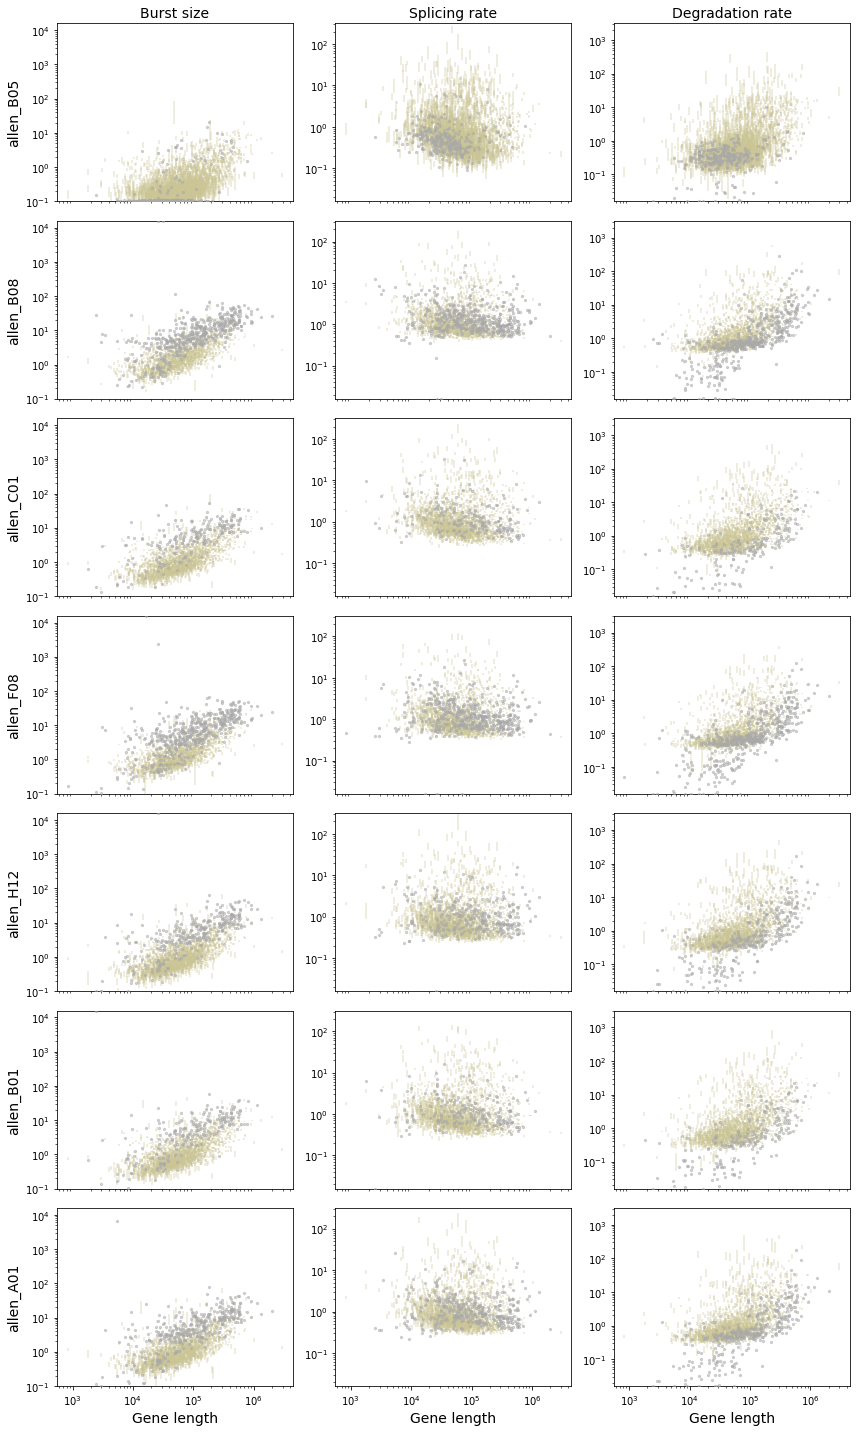

In [1449]:
plot_and_export_param_length_dependence_noisefree(3,figsize=(12,20))

#### v2/v3 comparison

In [1182]:
def plot_params_for_pair_noisefree(sr1,sr2,ax1,omit_rho=False):
    phys_params_1 = 10**sr1.phys_optimum
    phys_params_2 = 10**sr2.phys_optimum

    c = 2.576
    err_high_1 = 10**(sr1.phys_optimum + c*sr1.sigma) - phys_params_1
    err_low_1 = phys_params_1 - 10**(sr1.phys_optimum - c*sr1.sigma)
    err_high_2 = 10**(sr2.phys_optimum + c*sr2.sigma) - phys_params_2
    err_low_2 = phys_params_2 - 10**(sr2.phys_optimum - c*sr2.sigma)

    gf = (~sr1.rejected_genes) & (~sr2.rejected_genes)

    rho = []
    for k in range(3):
        x = phys_params_1[gf,k]
        y = phys_params_2[gf,k]
        ax1[k].errorbar(x,y,
                        xerr=[err_low_1[gf,k],err_high_1[gf,k]],
                        yerr=[err_low_2[gf,k],err_high_2[gf,k]],
                        color=aesthetics['accepted_gene_color'],
                       alpha=aesthetics['accepted_gene_alpha'],linestyle="None",zorder=-100)
        ax1[k].scatter(phys_params_1[~gf,k],phys_params_2[~gf,k],
                        color=aesthetics['rejected_gene_color'],
                       alpha=aesthetics['rejected_gene_alpha'],s=aesthetics['rejected_gene_ms'],zorder=100)
        ax1[k].set_xlim([10**sr1.sp.phys_lb[k],10**sr1.sp.phys_ub[k]])
        ax1[k].set_ylim([10**sr1.sp.phys_lb[k],10**sr1.sp.phys_ub[k]])
        xl = [10**sr1.sp.phys_lb[k],10**sr1.sp.phys_ub[k]]
        ax1[k].plot(xl,xl,'--',color=aesthetics['identity_line_color'],linewidth=aesthetics['identity_lw'],zorder=200)
        ax1[k].set_yscale('log')
        ax1[k].set_xscale('log')

In [1183]:
tech_v2_replicate_pairs

[[0, 2], [0, 2], [0, 2], [0, 5]]

Here, we perform a comparison between v2 and v3 datasets under the noise-free model. We find that the parameter values for technical replicates are biased relative to identity. This suggests that the fits are unreliable and should not be interpreted as they stand.

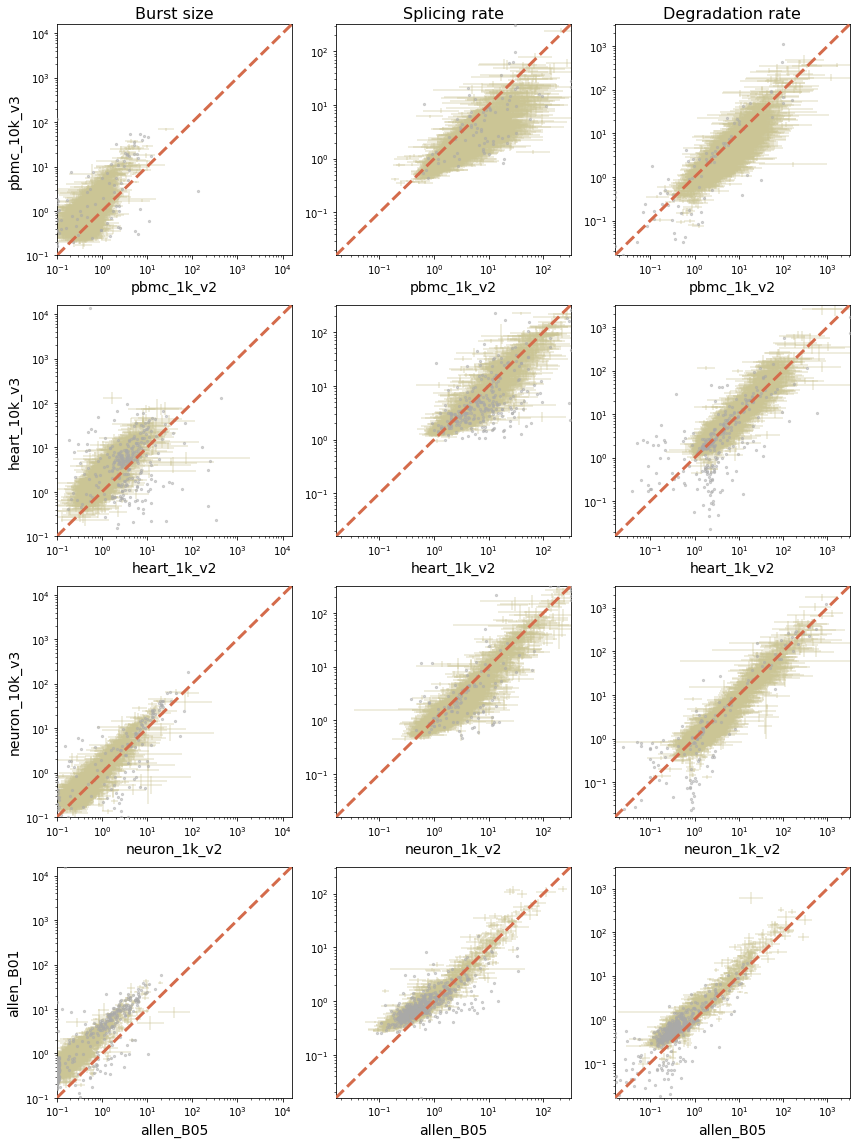

In [1756]:
n_pairs = len(batch_names)
fig1, ax1 = plt.subplots(nrows=n_pairs,ncols=3,figsize=(12,16))
for k in range(3):
    ax1[0,k].set_title(param_names[k],fontsize=aesthetics['fontsize_body_title'])

for batch_index in range(len(batch_names)):
    pair = tech_v2_replicate_pairs[batch_index]
    dataset_1 = dataset_name_list[batch_index][pair[0]]
    dataset_2 = dataset_name_list[batch_index][pair[1]]
    sr1 = monod.analysis.load_search_results('./fits/'+batch_dirs_noisefree[batch_index]+'/'+dataset_1+'/Bursty_None_1x1/grid_scan_results_upd.res')
    sr2 = monod.analysis.load_search_results('./fits/'+batch_dirs_noisefree[batch_index]+'/'+dataset_2+'/Bursty_None_1x1/grid_scan_results_upd.res')
    plot_params_for_pair_noisefree(sr1,sr2,ax1[batch_index])
    ax1[batch_index,0].set_ylabel(dataset_2,fontsize=aesthetics['fontsize_body_axes'])
    for k in range(3):
        ax1[batch_index,k].set_xlabel(dataset_1,fontsize=aesthetics['fontsize_body_axes'])

fig1.tight_layout()
fig1.savefig('./'+figdir+'/v2_noisefree_parameter_comparison.png',dpi=600)


# Fig. 2: the Poisson sampling model

## Panel a: structure of the model 

In Fig. 2a, we illustrate the sort of raw data obtainable by aligning or pseudoaligning scRNA-seq reads.

In [916]:
sd = monod.analysis.load_search_data('./fits/'+batch_dirs[0]+'/'+dataset_v3_list[0][1]+'/raw.sd')

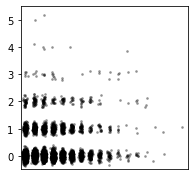

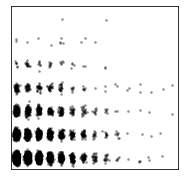

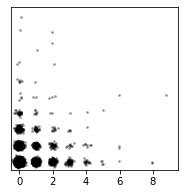

In [918]:
for k in range(3):
    fig1,ax1 = plt.subplots(figsize=(3,3))        
    jitter_magn = 0.1
    jitter = np.random.randn(2, sd.n_cells) * jitter_magn
    ax1.scatter(
        *sd.layers[:2, k] + jitter, c="k", s=3, alpha=0.3
    )

    ax1.set_xlim([-0.5, sd.M[0, k] - 9.5])
    ax1.set_ylim([-0.5, sd.M[1, k] - 9.5])
    
    if k==0:
        ax1.set_xticks([])
    elif k==1:
        ax1.set_xticks([])
        ax1.set_yticks([])
    elif k==2:
        ax1.set_yticks([])
    fig1.savefig(figdir+'/raw_data_'+sd.gene_names[k]+'.png',dpi=600)

## Panel b: parameter values

In [1450]:
def plot_param_length_dependence(sr,ax1):
    gene_lengths = 10**sr.gene_log_lengths
    phys_params = 10**sr.phys_optimum

    c = 2.576
    err_high = 10**(sr.phys_optimum + c*sr.sigma) - phys_params
    err_low = phys_params - 10**(sr.phys_optimum - c*sr.sigma)

    gf = ~sr.rejected_genes

#     fig1, ax1 = plt.subplots(nrows=1,ncols=3,figsize=(12,4))
    for k in range(3):
        ax1[k].errorbar(gene_lengths[gf],phys_params[gf,k],yerr=[err_low[gf,k],err_high[gf,k]],
                        color=aesthetics['accepted_gene_color'],
                       alpha=aesthetics['accepted_gene_alpha'],linestyle="None",zorder=-100)
        ax1[k].scatter(gene_lengths[~gf],phys_params[~gf,k],
                        color=aesthetics['rejected_gene_color'],
                       alpha=aesthetics['rejected_gene_alpha'],s=aesthetics['rejected_gene_ms'],zorder=100)
        ax1[k].set_ylim([10**sr.sp.phys_lb[k],10**sr.sp.phys_ub[k]])

        ax1[k].set_yscale('log')
        ax1[k].set_xscale('log')


In [1451]:
def plot_and_export_param_length_dependence(batch_index,figsize=(12,10)):
    dataset_names = dataset_name_list[batch_index]
    n_datasets = len(dataset_names)
    fig1, ax1 = plt.subplots(nrows=n_datasets,ncols=3,figsize=figsize)
    for k in range(n_datasets):
        dataset_name = dataset_names[k]
        sr = monod.analysis.load_search_results('./fits/'+batch_dirs[batch_index]+'/'+dataset_name+'/Bursty_Poisson_20x21/grid_scan_results_upd.res')
        plot_param_length_dependence(sr,ax1[k])
    for k in range(n_datasets):
        ax1[k,0].set_ylabel(dataset_names[k],fontsize=aesthetics['fontsize_body_axes'])
    for k in range(n_datasets-1):
        for j in range(3):
            ax1[k,j].set_xticks([])

    for k in range(3):
        ax1[0,k].set_title(param_names[k],fontsize=aesthetics['fontsize_body_axes'])
        ax1[n_datasets-1,k].set_xlabel('Gene length',fontsize=aesthetics['fontsize_body_axes'])

    fig1.tight_layout()
    fig1.savefig('./'+figdir+'/parameter_length_trends_'+batch_names[batch_index]+'.png',dpi=600)

In Fig. 2b, we show that we can define a model of length-dependent technical noise, and infer parameters that have a more plausible dependence on gene length.

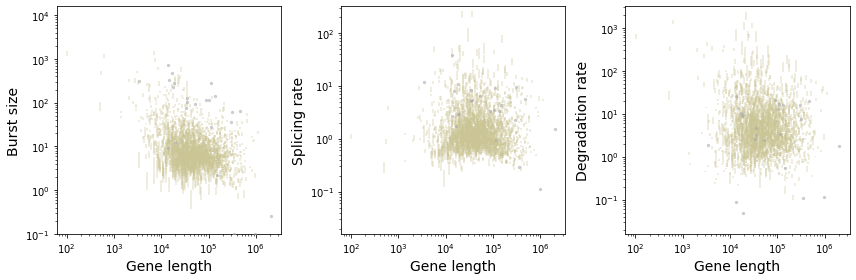

In [1453]:
sr = monod.analysis.load_search_results('./fits/'+batch_dirs[0]+'/'+dataset_v3_list[0][1]+'/Bursty_Poisson_20x21/grid_scan_results_upd.res')
fig1, ax1 = plt.subplots(nrows=1,ncols=3,figsize=(12,4))
plot_param_length_dependence(sr,ax1[:3])
param_names = ['Burst size','Splicing rate','Degradation rate']
for k in range(3):
    ax1[k].set_ylabel(param_names[k],fontsize=aesthetics['fontsize_body_axes'])
    ax1[k].set_xlabel('Gene length',fontsize=aesthetics['fontsize_body_axes'])
fig1.tight_layout()
fig1.savefig('./'+figdir+'/parameter_length_trends_subset.png',dpi=600)

### Supplements to 2b

#### PBMC

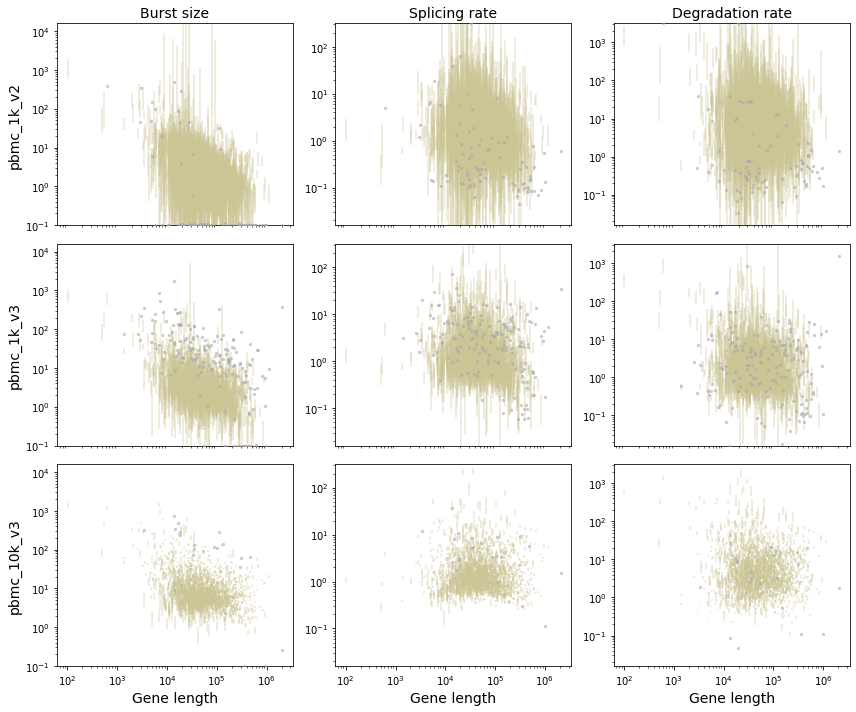

In [1454]:
plot_and_export_param_length_dependence(0)

#### Heart

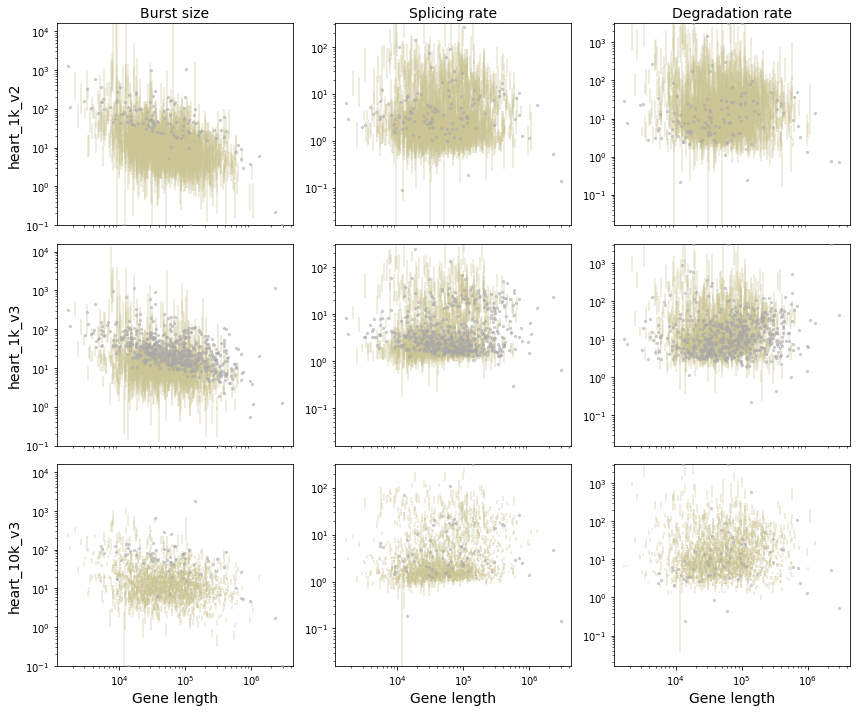

In [1455]:
plot_and_export_param_length_dependence(1)

#### Neuron

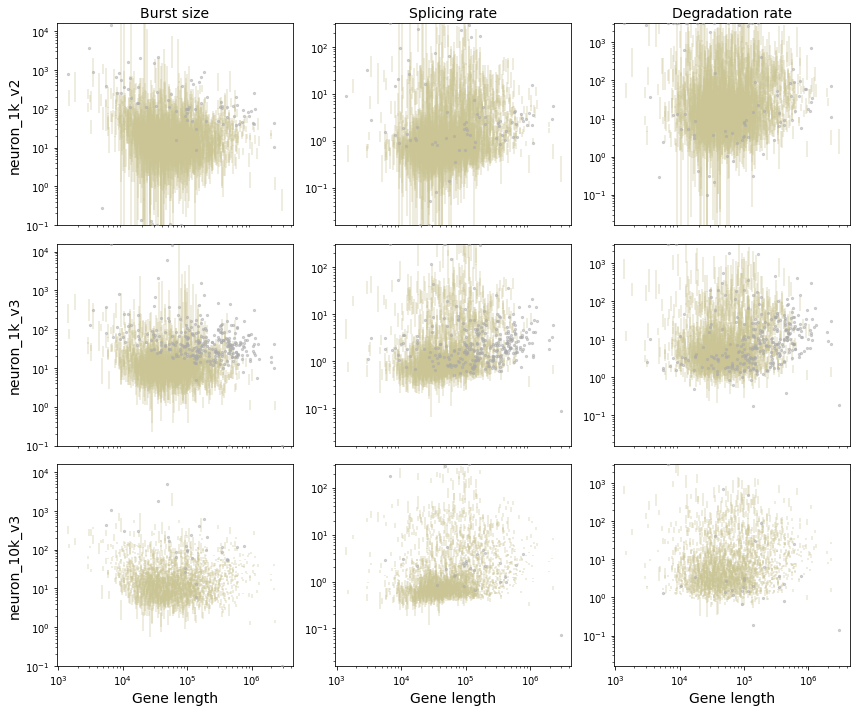

In [1456]:
plot_and_export_param_length_dependence(2)

#### Allen

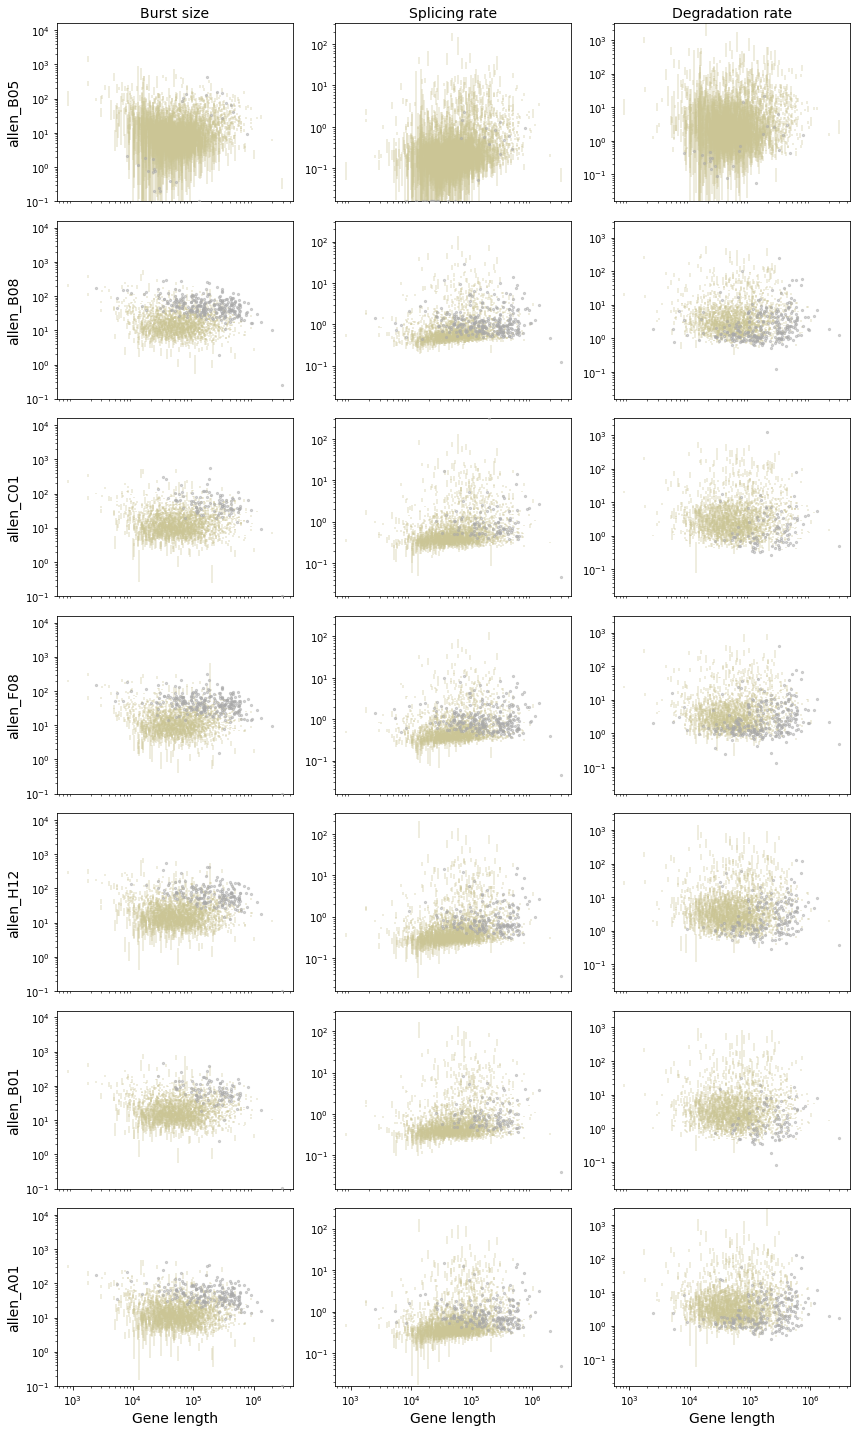

In [1457]:
plot_and_export_param_length_dependence(3,figsize=(12,20))

## Panel c: landscapes

In [1679]:
def plot_landscape(
    sr,
    ax,
    plot_optimum=True,
    gene_filter=None,
):

    total_divergence = sr.obj_func

    total_divergence = np.log10(total_divergence)

    dx = (np.asarray(sr.sp.samp_ub) - np.asarray(sr.sp.samp_lb)) / (
        np.asarray(sr.sp.gridsize) - 1
    )
    dx[dx < 1e-10] = 0.1
    extent = [
        sr.sp.samp_lb[0] - dx[0] / 2,
        sr.sp.samp_ub[0] + dx[0] / 2,
        sr.sp.samp_lb[1] - dx[1] / 2,
        sr.sp.samp_ub[1] + dx[1] / 2,
    ]
    q = np.quantile(total_divergence,0.05)
    lnd = ax.imshow(
        np.flipud(np.reshape(total_divergence, sr.sp.gridsize).T), extent=extent,
        cmap = aesthetics['landscape_colormap']
    )
    lnd = ax.imshow(
        np.flipud(np.reshape(total_divergence>q, sr.sp.gridsize).T), extent=extent,
        cmap = aesthetics['landscape_highlight_colormap'],alpha=0.5
    )

In [1684]:
opt_values = []
opt_colors = []

for j in range(len(batch_dirs)):
    dataset_names = dataset_v3_list[j]
    batch = batch_dirs[j]
    n_datasets = len(dataset_names)
    for k in range(n_datasets):
        dataset_name = dataset_names[k]
        sr = monod.analysis.load_search_results('./fits/'+batch+'/'+dataset_name
                                                +'/Bursty_Poisson_20x21/grid_scan_results_upd.res')
        opt_values.append(sr.samp_optimum)
        opt_colors.append(aesthetics['dataset_colors'][0])

opt_values = np.asarray(opt_values).T
opt_values_print = np.copy(opt_values.T)
opt_values += np.random.randn(opt_values.shape[0],opt_values.shape[1])/100

In [1688]:
opt_values_print.min(0)

array([-6.26315789, -0.875     ])

In [1689]:
opt_values_print.max(0)

array([-5.47368421, -0.25      ])

In [1691]:
(opt_values_print.max(0) - opt_values_print.min(0))/2 

array([0.39473684, 0.3125    ])

In [1692]:
(opt_values_print.max(0) - opt_values_print.min(0))/2 +  opt_values_print.min(0)

array([-5.86842105, -0.5625    ])

In Fig. 2c, we show that the sampling parameters are identifiable, at least to some extent: by scanning over a two-dimensional grid, we can observe fairly well-behaved and consistent KLD optima.

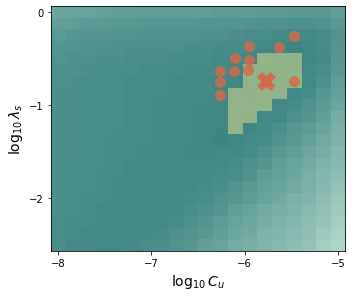

In [1693]:
fig1, ax1 = plt.subplots(figsize=(5,7))
sr = monod.analysis.load_search_results('./fits/'+batch_dirs[0]+'/'+dataset_v3_list[0][1]+'/Bursty_Poisson_20x21/grid_scan_results_upd.res')
plot_landscape(sr,ax1)
ax1.scatter(opt_values[0,:],opt_values[1,:],s=aesthetics['optimum_markersize'],color=aesthetics['optimum_color'],alpha=0.8)
ax1.scatter(opt_values[0,1],opt_values[1,1],s=aesthetics['highlighted_optimum_markersize'],color=aesthetics['optimum_color'],alpha=0.95,
           marker='X')

ax1.set_yticks([-2,-1,0])
ax1.set_xticks([-8,-7,-6,-5])
ax1.set_ylabel(r'$\log_{10} \lambda_s$',fontsize=aesthetics['fontsize_body_axes'])
ax1.set_xlabel(r'$\log_{10} C_u$',fontsize=aesthetics['fontsize_body_axes'])

fig1.tight_layout()
fig1.savefig('./'+figdir+'/landscape_v3.png',dpi=600)


### Supplements to 2c

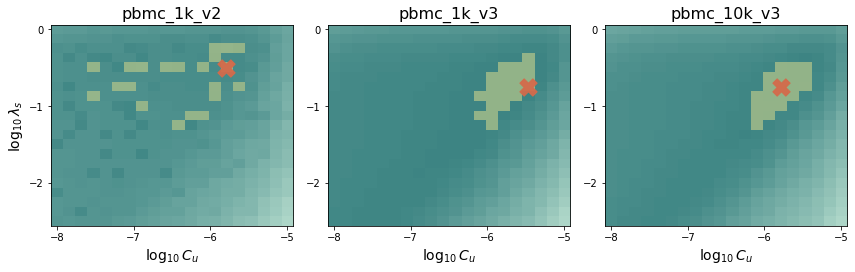

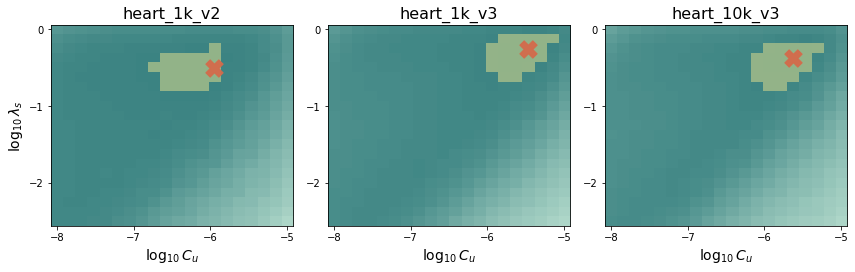

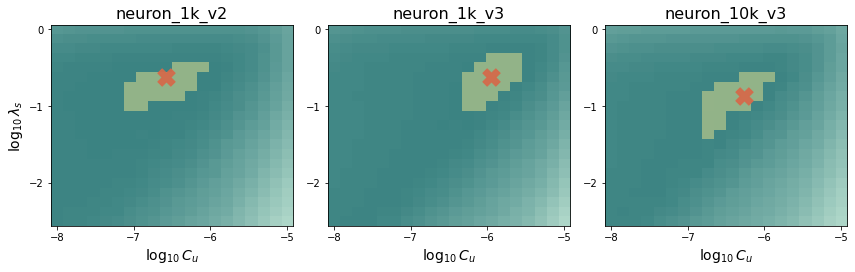

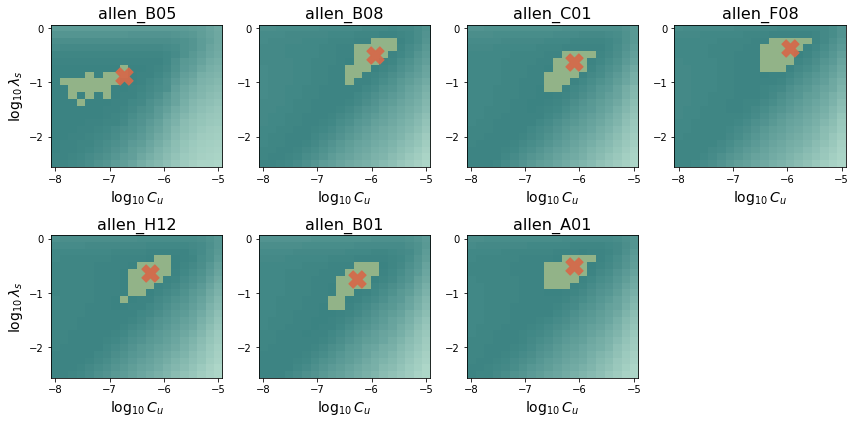

In [1032]:
opt_values = []
opt_colors = []

for j in range(len(batch_dirs)-1):
    dataset_names = dataset_name_list[j]
    fig1, ax1 = plt.subplots(nrows=1,ncols=len(dataset_names),figsize=(12,5))

    batch = batch_dirs[j]
    n_datasets = len(dataset_names)
    for k in range(n_datasets):
        dataset_name = dataset_names[k]
#         if j==0:
#             dataset_name = '10x_'+dataset_name+'_All'
        sr = monod.analysis.load_search_results('./fits/'+batch+'/'+dataset_name
                                                +'/Bursty_Poisson_20x21/grid_scan_results_upd.res')
        plot_landscape(sr,ax1[k])
        ax1[k].scatter(sr.samp_optimum[0],sr.samp_optimum[1],s=aesthetics['highlighted_optimum_markersize'],color=aesthetics['optimum_color'],alpha=0.95,
                   marker='X')
        ax1[k].set_title(dataset_names[k],fontsize=aesthetics['fontsize_body_title'])
        ax1[k].set_xlabel(r'$\log_{10} C_u$',fontsize=aesthetics['fontsize_body_axes'])
        ax1[k].set_yticks([-2,-1,0])
        ax1[k].set_xticks([-8,-7,-6,-5])
    ax1[0].set_ylabel(r'$\log_{10} \lambda_s$',fontsize=aesthetics['fontsize_body_axes'])
    fig1.tight_layout()
    fig1.savefig('./'+figdir+'/landscape_'+batch_names[j]+'.png',dpi=600)

for j in range(len(batch_dirs)-1,len(batch_dirs)):
    dataset_names = dataset_name_list[j]
    fig1, ax1 = plt.subplots(nrows=2,ncols=4,figsize=(12,6))

    batch = batch_dirs[j]
    n_datasets = len(dataset_names)
    for k in range(n_datasets):
        dataset_name = dataset_names[k]
        axloc = np.unravel_index(k,(2,4))
        sr = monod.analysis.load_search_results('./fits/'+batch+'/'+dataset_name
                                                +'/Bursty_Poisson_20x21/grid_scan_results_upd.res')
        plot_landscape(sr,ax1[axloc])
        ax1[axloc].scatter(sr.samp_optimum[0],sr.samp_optimum[1],s=aesthetics['highlighted_optimum_markersize'],color=aesthetics['optimum_color'],alpha=0.95,
                   marker='X')
        ax1[axloc].set_title(dataset_names[k],fontsize=aesthetics['fontsize_body_title'])
#         if k>3:
        ax1[axloc].set_xlabel(r'$\log_{10} C_u$',fontsize=aesthetics['fontsize_body_axes'])
        ax1[axloc].set_yticks([-2,-1,0])
        ax1[axloc].set_xticks([-8,-7,-6,-5])
    ax1[0,0].set_ylabel(r'$\log_{10} \lambda_s$',fontsize=aesthetics['fontsize_body_axes'])
    ax1[1,0].set_ylabel(r'$\log_{10} \lambda_s$',fontsize=aesthetics['fontsize_body_axes'])
    plt.delaxes(ax1[1,3])
    fig1.tight_layout()
    fig1.savefig('./'+figdir+'/landscape_'+batch_names[j]+'.png',dpi=600)


    

## Panel d: distributions

In [1115]:
def plot_gene_distributions(
    sr,
    sd,
    filename,
    sz=(2, 3),
    figsize=(8, 5),
    logscale=True,
    title=True,
    genes_to_plot=None,
):

    (nrows, ncols) = sz
    fig1, ax1 = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize)

    nax = np.prod(sz)
    if genes_to_plot is None:
        genes_to_plot = np.arange(nax)

    genes_to_plot = np.asarray(genes_to_plot)
    if genes_to_plot.dtype == bool:
        gtp_temp = np.arange(sr.n_genes)
        genes_to_plot = gtp_temp[genes_to_plot]

    number_of_genes_to_plot = len(genes_to_plot)
    if number_of_genes_to_plot > sr.n_genes:
        number_of_genes_to_plot = sr.n_genes
        genes_to_plot = genes_to_plot[: sr.n_genes]
    if number_of_genes_to_plot > nax:  # This should no longer break...
        number_of_genes_to_plot = nax
        genes_to_plot = genes_to_plot[:nax]

    j_ = 0
    for i_ in genes_to_plot:
        lm = np.copy(sd.M[:, i_])
        axloc = np.unravel_index(j_, sz) if (sz[0] > 1 and sz[1] > 1) else j_
        if i_>2:
            ax1[axloc].set_xlabel('Unspliced',fontsize=aesthetics['fontsize_body_axes'])
        if i_%3==0:
            ax1[axloc].set_ylabel('Spliced',fontsize=aesthetics['fontsize_body_axes'])
            
        samp = sr.regressor_optimum[i_]
        Pa = np.squeeze(sr.model.eval_model_pss(sr.phys_optimum[i_], lm, samp))

        if logscale:
            Pa[Pa < 1e-10] = 1e-10
            Pa = np.log10(Pa)

        ax1[axloc].imshow(Pa.T, aspect="auto", cmap=aesthetics['pmf_colormap'])
        ax1[axloc].invert_yaxis()
#         print(sd.M[:,i_])

        jitter_magn = 0.1
        jitter = np.random.randn(2, sr.n_cells) * jitter_magn
        ax1[axloc].scatter(
            *sd.layers[:2, i_] + jitter, c="k", s=1, alpha=0.1
        )

        ax1[axloc].set_xlim([-0.5, sd.M[0, i_] - 5.5])
        ax1[axloc].set_ylim([-0.5, sd.M[1, i_] - 5.5])
        if title:
            titlestr = sr.gene_names[i_]
            if hasattr(sr, "rejected_genes") and sr.rejected_genes[i_]:
                titlestr += " (rej.)"
            ax1[axloc].text(.05,.8,titlestr,transform=ax1[axloc].transAxes,fontsize=25)

        ax1[axloc].set_xticks([])
        ax1[axloc].set_yticks([])
        j_ += 1
    
    fig1.tight_layout(pad=0.02)
    
    fig1.savefig(figdir+'/'+filename+'.png',dpi=600)
    

In [1116]:
sr = monod.analysis.load_search_results('./fits/'+batch_dirs[0]+'/'+dataset_v3_list[0][1]+'/Bursty_Poisson_20x21/grid_scan_results_upd.res')
sd = monod.analysis.load_search_data('./fits/'+batch_dirs[0]+'/'+dataset_v3_list[0][1]+'/raw.sd')

In Fig. 2d, we show that the fits recapitulate the two-dimensional distributions observed in the data.

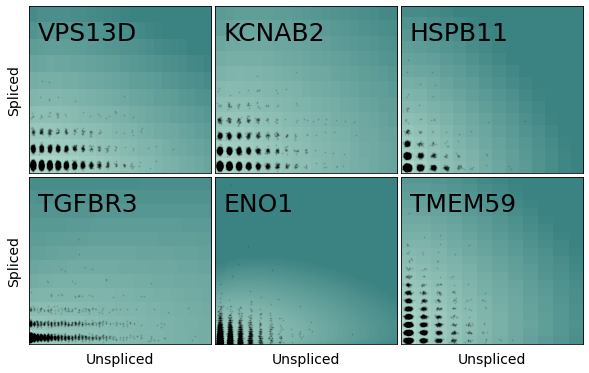

In [1117]:
plot_gene_distributions(sr,sd,'gene_histogram')

# Figure 3: Parameter distributions and distributions reproducibility

## Panel a: parameter distributions

In [1118]:
def plot_param_marg(sr,ax1,nbin=25):
    gf = ~sr.rejected_genes
    phys_params = sr.phys_optimum[gf]
    param_names = ['Burst size','Splicing rate','Degradation rate']
    fitlaw=scipy.stats.norminvgauss
    fitlaws_ = []
    for k in range(3):            
        ax1[k].hist(
                phys_params[:, k],
                nbin,
                density=True,
                color=aesthetics["hist_face_color"],
            )

        ax1[k].set_xlim([sr.sp.phys_lb[k],sr.sp.phys_ub[k]])
        fitparams = fitlaw.fit(phys_params[:, k])

        xmin, xmax = ax1[k].get_xlim()
        x = np.linspace(xmin, xmax, 100)
        p = fitlaw.pdf(x, *fitparams)
        ax1[k].plot(
            x,
            p,
            "--",
            linewidth=aesthetics["hist_fit_lw"],
            color=aesthetics["hist_fit_color"],
        )
        fitlaws_.append(fitparams)
    return fitlaws_


In [1119]:
sr = monod.analysis.load_search_results('./fits/'+batch_dirs[0]+'/'+dataset_v3_list[0][1]+'/Bursty_Poisson_20x21/grid_scan_results_upd.res')

In Fig. 3a, we show that the inferred parameter values have fairly simple unimodal distributions.

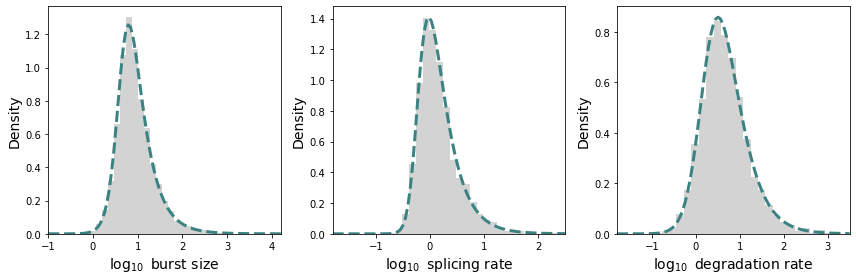

In [1120]:
fig1, ax1 = plt.subplots(nrows=1,ncols=3,figsize=(12,4))
plot_param_marg(sr,ax1[:3])

param_names = ['burst size','splicing rate','degradation rate']

for k in range(3):
    ax1[k].set_xlabel(r'$\log_{10}$ ' + param_names[k],fontsize=aesthetics['fontsize_body_axes'])
    ax1[k].set_ylabel('Density',fontsize=aesthetics['fontsize_body_axes'])
fig1.tight_layout()
fig1.savefig('./'+figdir+'/parameter_distributions_subset.png',dpi=600)

### Supplements to 3a

In [1068]:
fitlaws = []


In [1069]:
def plot_and_export_param_marg(batch_index,figsize=(12,10)):
    dataset_names = dataset_name_list[batch_index]
    n_datasets = len(dataset_names)
    fig1, ax1 = plt.subplots(nrows=n_datasets,ncols=3,figsize=figsize)
    fitlaws_ = []
    for k in range(n_datasets):
        dataset_name = dataset_names[k]
        sr = monod.analysis.load_search_results('./fits/'+batch_dirs[batch_index]+'/'+dataset_name+'/Bursty_Poisson_20x21/grid_scan_results_upd.res')
        fitlaws_.append(plot_param_marg(sr,ax1[k]))
    for k in range(n_datasets):
        ax1[k,0].set_ylabel(dataset_names[k],fontsize=aesthetics['fontsize_body_axes'])
    for k in range(n_datasets-1):
        for j in range(3):
            ax1[k,j].set_xticks([])

    for k in range(3):
        ax1[n_datasets-1,k].set_xlabel(r'$\log_{10}$ ' + param_names[k].lower(),fontsize=aesthetics['fontsize_body_axes'])

    fig1.tight_layout()
    fig1.savefig('./'+figdir+'/parameter_distributions_'+batch_names[batch_index]+'.png',dpi=600)
    return fitlaws_

#### PBMC

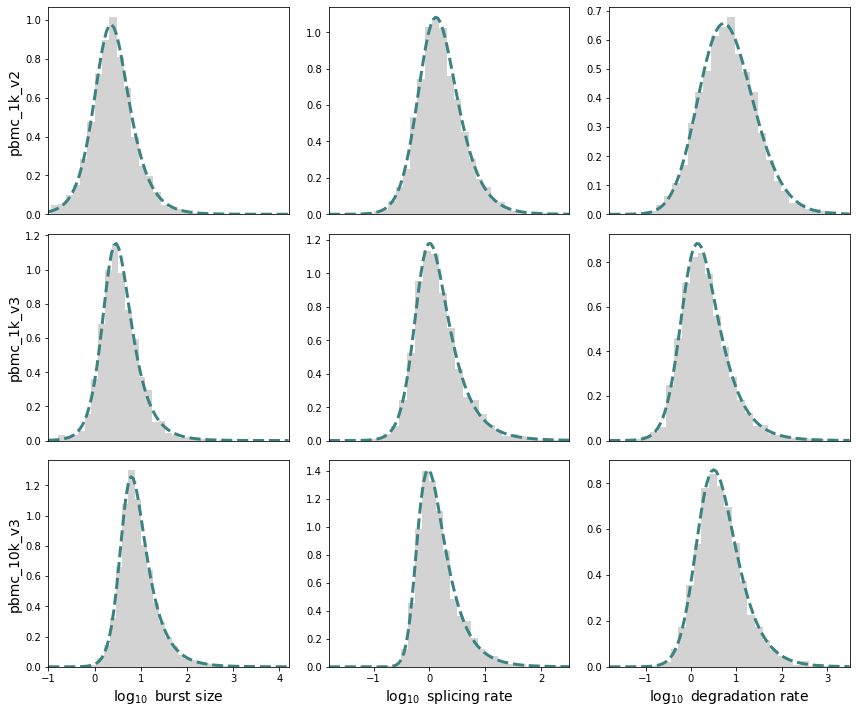

In [1070]:
fitlaws_ = plot_and_export_param_marg(0)
fitlaws.extend(fitlaws_)

#### Heart

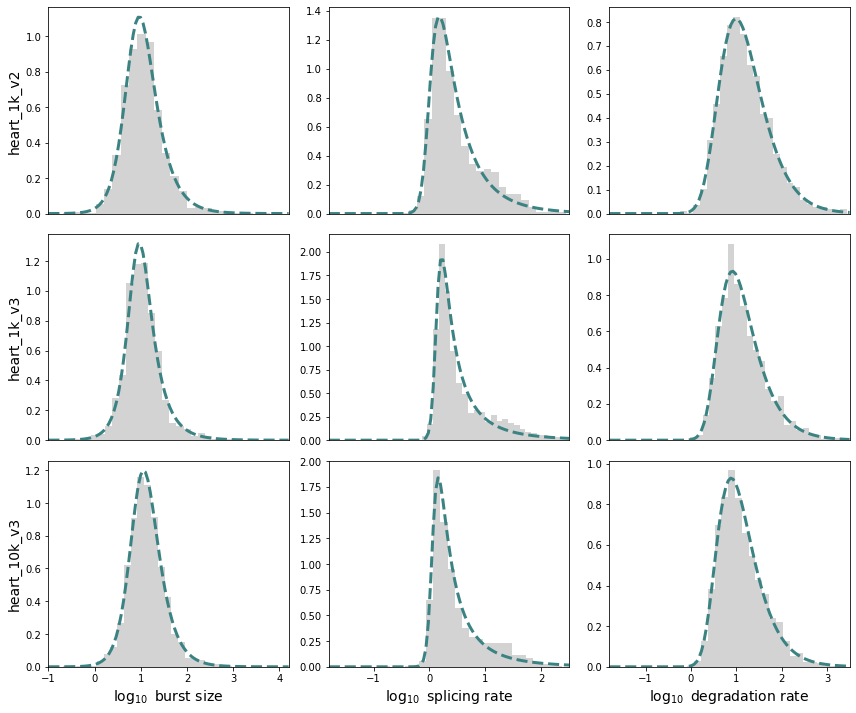

In [1071]:
fitlaws_ = plot_and_export_param_marg(1)
fitlaws.extend(fitlaws_)

#### Neuron

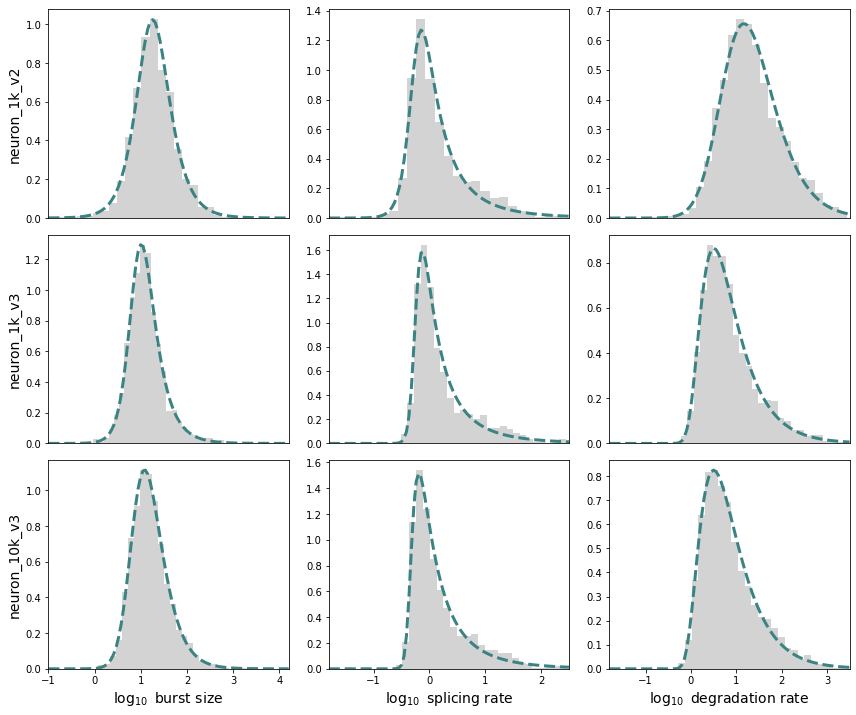

In [1072]:
fitlaws_ = plot_and_export_param_marg(2)
fitlaws.extend(fitlaws_)

#### Allen

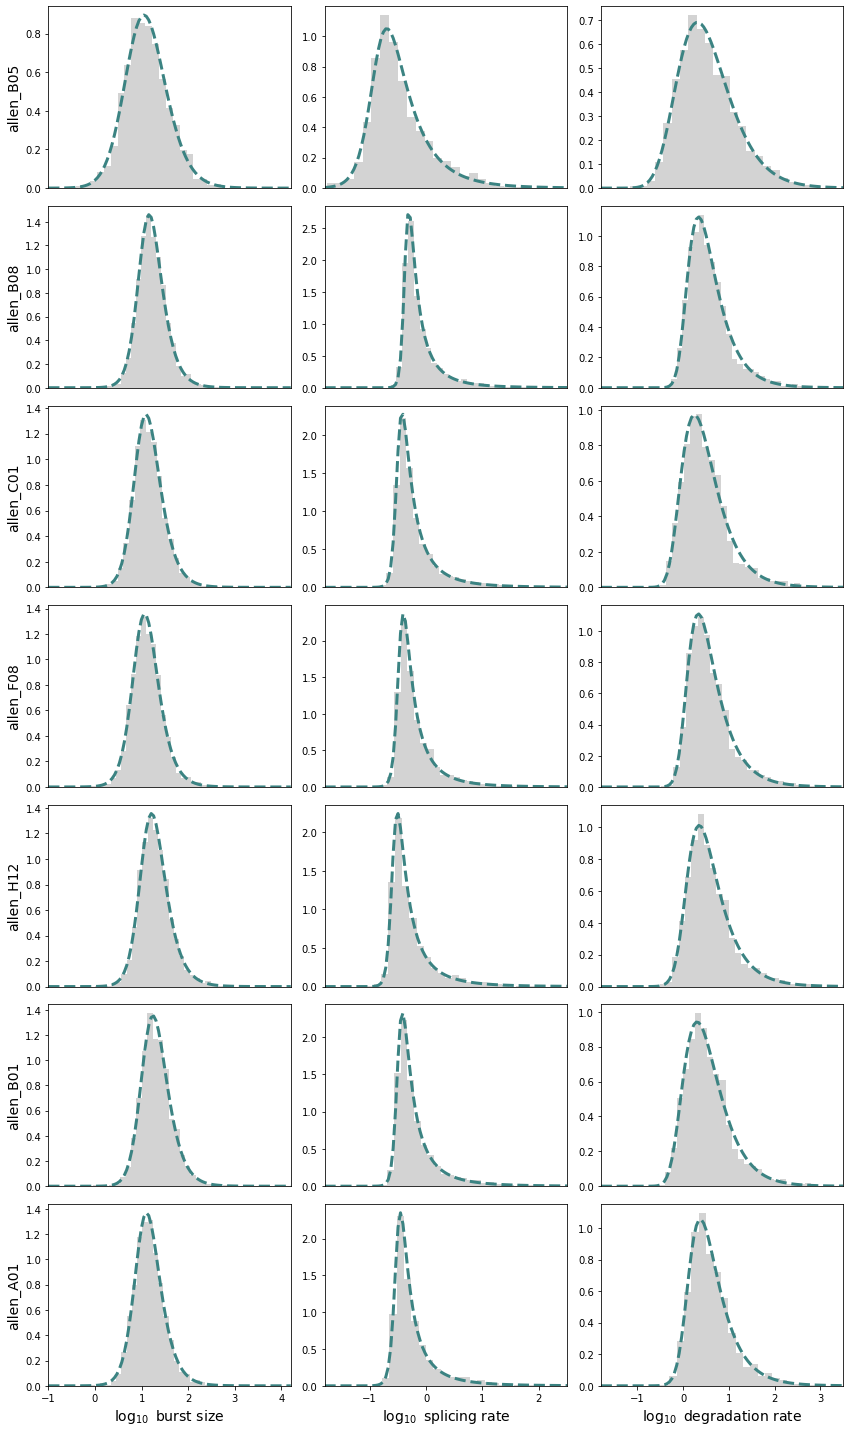

In [1073]:
fitlaws_ = plot_and_export_param_marg(3,figsize=(12,20))
fitlaws.extend(fitlaws_)

#### Aggregated

In [1074]:
fitlaws = np.asarray(fitlaws)

In [1075]:
fitlaws_2 = fitlaws[[1,2,4,5,7,8,10,11,12,13,14,15]]

In [1076]:
aesthetics['dataset_colors']

('violet', 'darkorchid', 'rebeccapurple', 'midnightblue')

In [1077]:
law_colors = [aesthetics['dataset_colors'][0]]*2 + \
             [aesthetics['dataset_colors'][1]]*2 + \
             [aesthetics['dataset_colors'][2]]*2 + \
             [aesthetics['dataset_colors'][3]]*6 

Here, we show that the parameter distributions are comparable between datasets, although some biases occur. These may be attributable to real physiological differences or to limitations of the technical noise inference procedure.

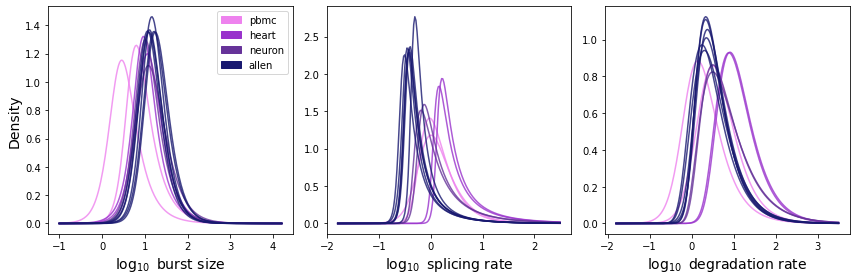

In [1078]:
fig1, ax1 = plt.subplots(nrows=1,ncols=3,figsize=(12,4))
for k in range(3):
    x = np.linspace(sr.sp.phys_lb[k],sr.sp.phys_ub[k],200)
    fitlaw=scipy.stats.norminvgauss
    for j in range(len(fitlaws_2)):
        p = fitlaw.pdf(x, *fitlaws_2[j][k])
        ax1[k].plot(x,p,'-',color=law_colors[j],alpha=0.8)
handles, labels = ax1[0].get_legend_handles_labels()        
for k in range(4):
    legend_patch = mpatches.Patch(color=aesthetics['dataset_colors'][k], label=batch_names[k])
    handles.append(legend_patch)
ax1[0].legend(handles=handles)    

for k in range(3):
    ax1[k].set_xlabel(r'$\log_{10}$ ' + param_names[k].lower(),fontsize=aesthetics['fontsize_body_axes'])
ax1[0].set_ylabel('Density',fontsize=aesthetics['fontsize_body_axes'])
fig1.tight_layout()
fig1.savefig('./'+figdir+'/parameter_distributions_fitlaws_v3.png',dpi=600)


## Panel 3b: biological replicate comparisons

In [1079]:
def plot_params_for_pair(sr1,sr2,ax1,omit_rho=False):
    phys_params_1 = 10**sr1.phys_optimum
    phys_params_2 = 10**sr2.phys_optimum

    c = 2.576
    err_high_1 = 10**(sr1.phys_optimum + c*sr1.sigma) - phys_params_1
    err_low_1 = phys_params_1 - 10**(sr1.phys_optimum - c*sr1.sigma)
    err_high_2 = 10**(sr2.phys_optimum + c*sr2.sigma) - phys_params_2
    err_low_2 = phys_params_2 - 10**(sr2.phys_optimum - c*sr2.sigma)

    gf = (~sr1.rejected_genes) & (~sr2.rejected_genes)

    rho = []
    for k in range(3):
        x = phys_params_1[gf,k]
        y = phys_params_2[gf,k]
        ax1[k].errorbar(x,y,
                        xerr=[err_low_1[gf,k],err_high_1[gf,k]],
                        yerr=[err_low_2[gf,k],err_high_2[gf,k]],
                        color=aesthetics['accepted_gene_color'],
                       alpha=aesthetics['accepted_gene_alpha'],linestyle="None",zorder=-100)
        ax1[k].scatter(phys_params_1[~gf,k],phys_params_2[~gf,k],
                        color=aesthetics['rejected_gene_color'],
                       alpha=aesthetics['rejected_gene_alpha'],s=aesthetics['rejected_gene_ms'],zorder=100)
        ax1[k].set_xlim([10**sr1.sp.phys_lb[k],10**sr1.sp.phys_ub[k]])
        ax1[k].set_ylim([10**sr1.sp.phys_lb[k],10**sr1.sp.phys_ub[k]])
        xl = [10**sr1.sp.phys_lb[k],10**sr1.sp.phys_ub[k]]
        ax1[k].plot(xl,xl,'--',color=aesthetics['identity_line_color'],linewidth=aesthetics['identity_lw'],zorder=200)
        ax1[k].set_yscale('log')
        ax1[k].set_xscale('log')
        rho_ = np.corrcoef(np.log10(x),np.log10(y))[0,1]
        if not omit_rho:
            ax1[k].text(.05,.85,r'$\rho$ = {:.2f}'.format(rho_),fontsize=aesthetics['fontsize_body_title'],transform=ax1[k].transAxes)
        rho.append(rho_)
    return np.asarray(rho)

In Fig. 3b, we show that biological replicates give largely concordant parameter values.

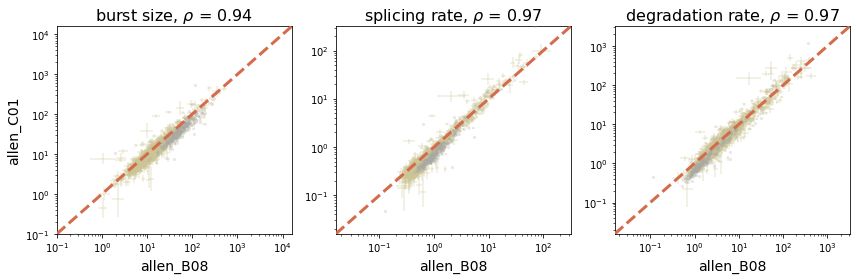

In [1080]:
fig1, ax1 = plt.subplots(nrows=1,ncols=3,figsize=(12,4))
axind = 0

batch_index = 3
pair = [0,1]
dataset_1 = dataset_v3_list[batch_index][pair[0]]
dataset_2 = dataset_v3_list[batch_index][pair[1]]
sr1 = monod.analysis.load_search_results('./fits/'+batch_dirs[batch_index]+'/'+dataset_1+'/Bursty_Poisson_20x21/grid_scan_results_upd.res')
sr2 = monod.analysis.load_search_results('./fits/'+batch_dirs[batch_index]+'/'+dataset_2+'/Bursty_Poisson_20x21/grid_scan_results_upd.res')
rho = plot_params_for_pair(sr1,sr2,ax1,omit_rho=True)
ax1[0].set_ylabel(dataset_2,fontsize=aesthetics['fontsize_body_axes'])
for k in range(3):
    ax1[k].set_xlabel(dataset_1,fontsize=aesthetics['fontsize_body_axes'])
    ax1[k].set_title(param_names[k]+ r', $\rho$ = {:.2f}'.format(rho[k]),fontsize=aesthetics['fontsize_body_title'])

fig1.tight_layout()
fig1.savefig('./'+figdir+'/biological_replicates_subset.png',dpi=600)


### Supplements to 3b

#### Technical replicates

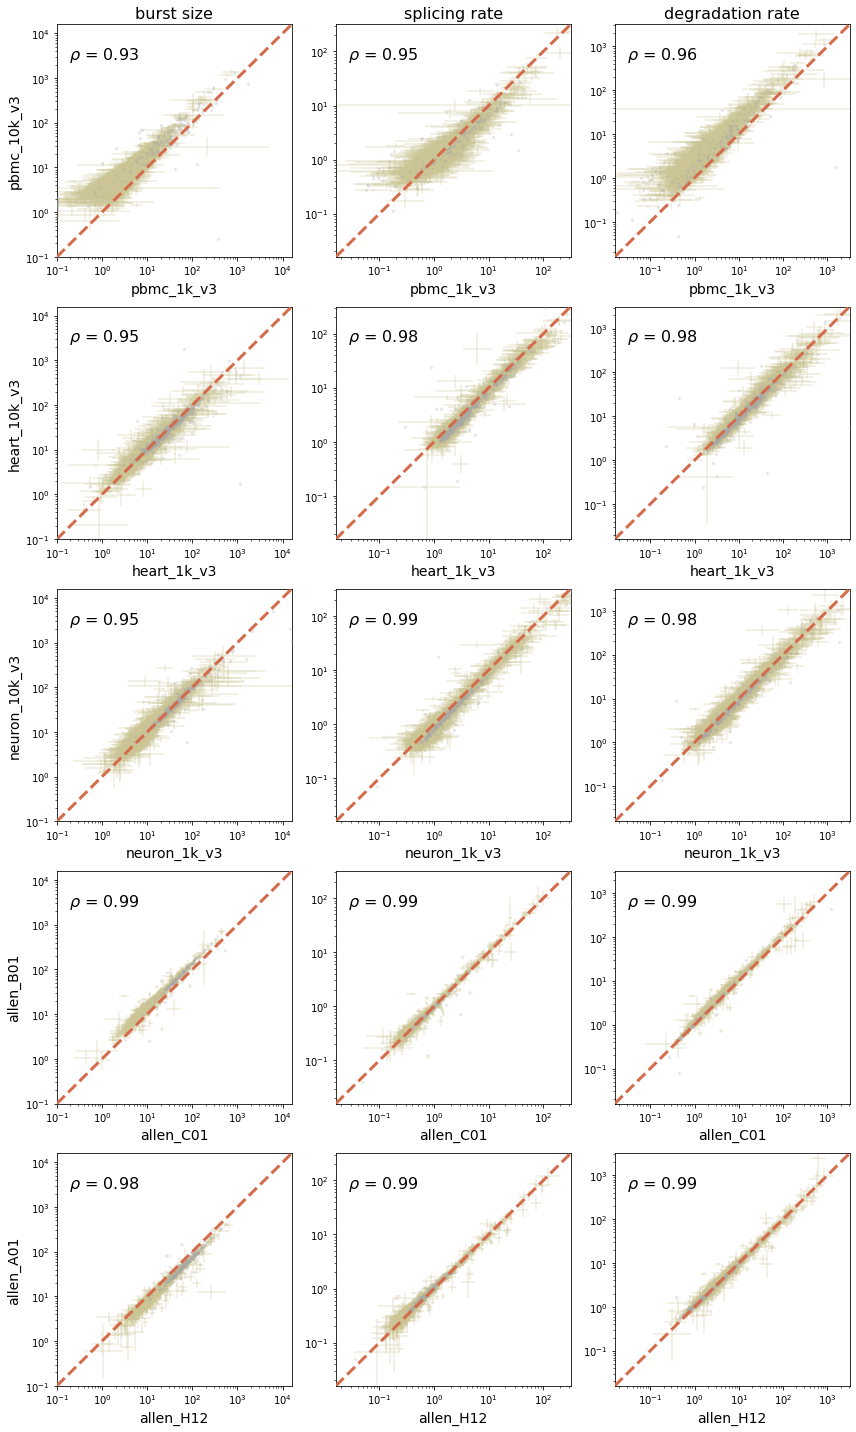

In [1081]:
n_pairs = len(np.concatenate(tech_replicate_pairs))
fig1, ax1 = plt.subplots(nrows=n_pairs,ncols=3,figsize=(12,20))
axind = 0
for k in range(3):
    ax1[0,k].set_title(param_names[k],fontsize=aesthetics['fontsize_body_title'])

for batch_index in range(len(batch_names)):
    for pair in tech_replicate_pairs[batch_index]:
        dataset_1 = dataset_v3_list[batch_index][pair[0]]
        dataset_2 = dataset_v3_list[batch_index][pair[1]]
        sr1 = monod.analysis.load_search_results('./fits/'+batch_dirs[batch_index]+'/'+dataset_1+'/Bursty_Poisson_20x21/grid_scan_results_upd.res')
        sr2 = monod.analysis.load_search_results('./fits/'+batch_dirs[batch_index]+'/'+dataset_2+'/Bursty_Poisson_20x21/grid_scan_results_upd.res')
        plot_params_for_pair(sr1,sr2,ax1[axind])
        ax1[axind,0].set_ylabel(dataset_2,fontsize=aesthetics['fontsize_body_axes'])
        for k in range(3):
            ax1[axind,k].set_xlabel(dataset_1,fontsize=aesthetics['fontsize_body_axes'])
        axind += 1

fig1.tight_layout()
fig1.savefig('./'+figdir+'/technical_replicates.png',dpi=600)


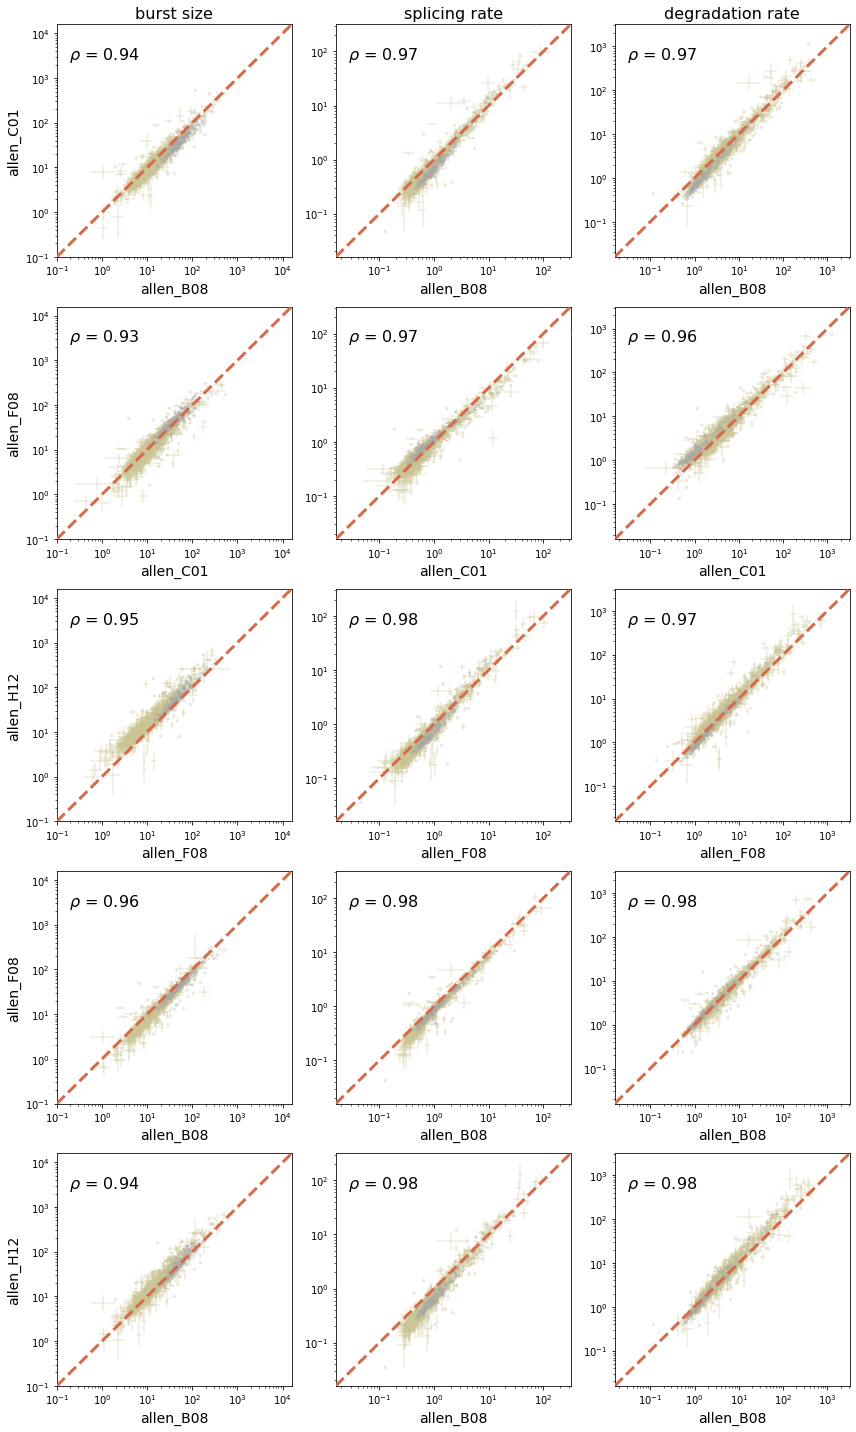

In [1082]:
n_pairs = len(bio_replicate_pairs[-1])
fig1, ax1 = plt.subplots(nrows=n_pairs,ncols=3,figsize=(12,20))
axind = 0
for k in range(3):
    ax1[0,k].set_title(param_names[k],fontsize=aesthetics['fontsize_body_title'])

for batch_index in range(len(batch_names)):
    for pair in bio_replicate_pairs[batch_index]:
        dataset_1 = dataset_v3_list[batch_index][pair[0]]
        dataset_2 = dataset_v3_list[batch_index][pair[1]]
        sr1 = monod.analysis.load_search_results('./fits/'+batch_dirs[batch_index]+'/'+dataset_1+'/Bursty_Poisson_20x21/grid_scan_results_upd.res')
        sr2 = monod.analysis.load_search_results('./fits/'+batch_dirs[batch_index]+'/'+dataset_2+'/Bursty_Poisson_20x21/grid_scan_results_upd.res')
        plot_params_for_pair(sr1,sr2,ax1[axind])
        ax1[axind,0].set_ylabel(dataset_2,fontsize=aesthetics['fontsize_body_axes'])
        for k in range(3):
            ax1[axind,k].set_xlabel(dataset_1,fontsize=aesthetics['fontsize_body_axes'])
        axind += 1

fig1.tight_layout()
fig1.savefig('./'+figdir+'/biological_replicates.png',dpi=600)


## Panels c-d: technical noise lowers the mean and increases variability in v2 samples

In Fig. 3c-d, we show that matched v2 data have lower average RNA counts and higher noise levels than v3 data.

In [1083]:
def compare_statistics_v2(X1,X2,ax1,which='mean'):
    pairs = [[1,0],[2,0],[1,2]]

    if which=='mean':
        x = X1.mean(1)
        y = X2.mean(1)
    elif which=='CV2':
        x = X1.var(1)/(X1.mean(1)**2)
        y = X2.var(1)/(X2.mean(1)**2)
    gf = (~np.isnan(x)) & (~np.isnan(y)) & (x>0) & (y>0)
    x = x[gf]
    y = y[gf]
    ax1.scatter(x,y,s=aesthetics['selected_markersize_body'],c=aesthetics['v2_gene_color'],alpha=aesthetics['selected_alpha'])
    ax1.set_xscale('log')
    ax1.set_yscale('log')
    xl = [x.min(),y.max()]
    ax1.plot(xl,xl,'--',color=aesthetics['identity_line_color'],linewidth=aesthetics['identity_lw'],zorder=200)


/tmp/ipykernel_3463100/1344158236.py:8: RuntimeWarning: invalid value encountered in divide
  x = X1.var(1)/(X1.mean(1)**2)
/tmp/ipykernel_3463100/1344158236.py:9: RuntimeWarning: invalid value encountered in divide
  y = X2.var(1)/(X2.mean(1)**2)


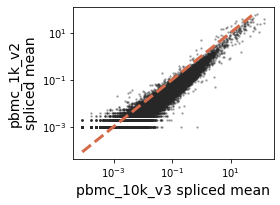

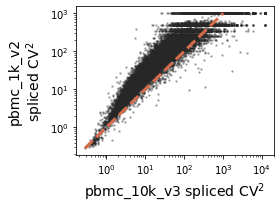

In [1084]:
batch_index = 0
loom_filepaths = [raw_looms[batch_index][tech_v2_replicate_pairs[batch_index][1]],
                  raw_looms[batch_index][tech_v2_replicate_pairs[batch_index][0]]]
datasets = [dataset_name_list[batch_index][tech_v2_replicate_pairs[batch_index][1]],
            dataset_name_list[batch_index][tech_v2_replicate_pairs[batch_index][0]]]
S_arr = []
for file in loom_filepaths:
    with lp.connect(file,mode='r') as ds:
        S_arr.append(ds.layers[spliced_layer][:])

fig1,ax1=plt.subplots(1,1,figsize=(4,3))
compare_statistics_v2(S_arr[0],S_arr[1],ax1)
ax1.set_xlabel(datasets[0]+' spliced mean',fontsize=aesthetics['fontsize_body_axes'])
ax1.set_ylabel(datasets[1]+'\nspliced mean',fontsize=aesthetics['fontsize_body_axes'])
fig1.tight_layout()
fig1.savefig('./'+figdir+'/v2_mean_subset.png',dpi=600)

fig1,ax1=plt.subplots(1,1,figsize=(4,3))
compare_statistics_v2(S_arr[0],S_arr[1],ax1,which='CV2')
ax1.set_xlabel(datasets[0]+' spliced '+r'CV${}^2$',fontsize=aesthetics['fontsize_body_axes'])
ax1.set_ylabel(datasets[1]+'\nspliced '+r'CV${}^2$',fontsize=aesthetics['fontsize_body_axes'])
fig1.tight_layout()
fig1.savefig('./'+figdir+'/v2_cv2_subset.png',dpi=600)

### Supplements to 3c-d

/tmp/ipykernel_3463100/1344158236.py:8: RuntimeWarning: invalid value encountered in divide
  x = X1.var(1)/(X1.mean(1)**2)
/tmp/ipykernel_3463100/1344158236.py:9: RuntimeWarning: invalid value encountered in divide
  y = X2.var(1)/(X2.mean(1)**2)


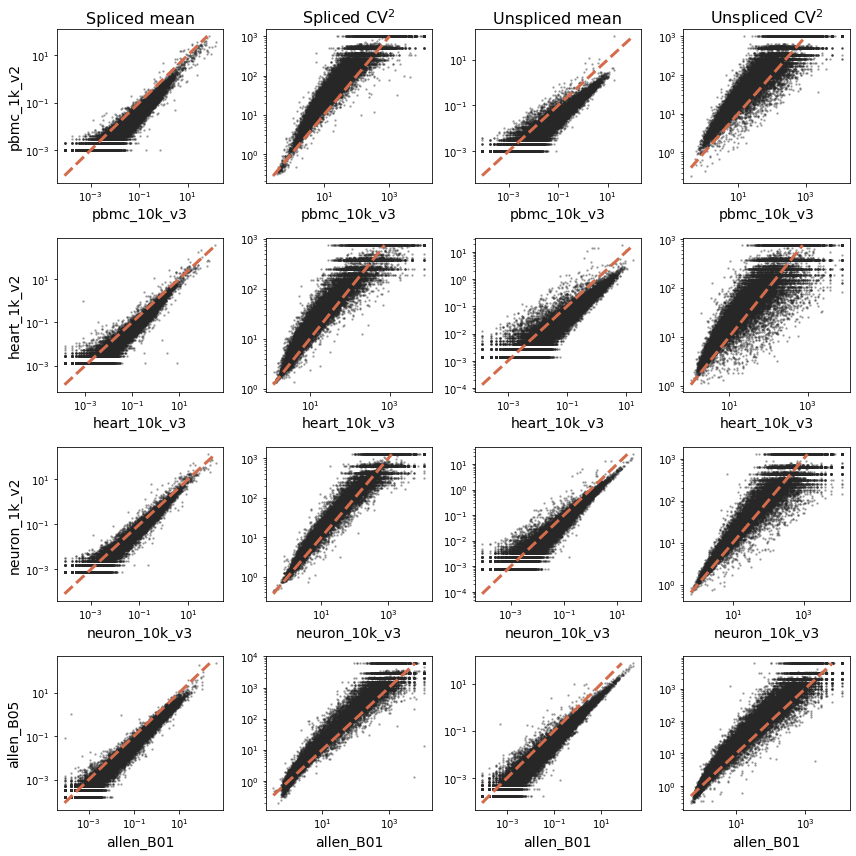

In [1085]:
fig1, ax1 = plt.subplots(nrows=len(batch_names),ncols=4,figsize=(12,12))
for batch_index in range(len(batch_names)):
    loom_filepaths = [raw_looms[batch_index][tech_v2_replicate_pairs[batch_index][1]],
                  raw_looms[batch_index][tech_v2_replicate_pairs[batch_index][0]]]
    datasets = [dataset_name_list[batch_index][tech_v2_replicate_pairs[batch_index][1]],
                dataset_name_list[batch_index][tech_v2_replicate_pairs[batch_index][0]]]
    S_arr = []
    U_arr = []
    for file in loom_filepaths:
        with lp.connect(file,mode='r') as ds:
            S_arr.append(ds.layers[spliced_layer][:])
            U_arr.append(ds.layers[unspliced_layer][:])
    compare_statistics_v2(S_arr[0],S_arr[1],ax1[batch_index,0])
    compare_statistics_v2(S_arr[0],S_arr[1],ax1[batch_index,1],'CV2')
    compare_statistics_v2(U_arr[0],U_arr[1],ax1[batch_index,2])
    compare_statistics_v2(U_arr[0],U_arr[1],ax1[batch_index,3],'CV2')
    
    ax1[batch_index,0].set_ylabel(datasets[1],fontsize=aesthetics['fontsize_body_axes'])
    for k in range(4):
        ax1[batch_index,k].set_xlabel(datasets[0],fontsize=aesthetics['fontsize_body_axes'])
ax1[0,0].set_title('Spliced mean',fontsize=aesthetics['fontsize_body_title'])
ax1[0,1].set_title(r'Spliced CV${}^2$',fontsize=aesthetics['fontsize_body_title'])
ax1[0,2].set_title('Unspliced mean',fontsize=aesthetics['fontsize_body_title'])
ax1[0,3].set_title(r'Unspliced CV${}^2$',fontsize=aesthetics['fontsize_body_title'])
fig1.tight_layout()
fig1.savefig('./'+figdir+'/v2_statistics.png',dpi=600)

## Panel e: technical noise as an explanatory mechanism for biases

In [1086]:
batch_dirs

['gg_221118_025_pbmc_1',
 'gg_221115_025_heart_1',
 'gg_221116_025_neuron_1',
 'gg_221118_025_allen_1']

In Fig. 3e, we attempt to infer the sampling parameters for v2 data, and find that they are consistently lower than the v3 parameters.

In [1087]:
opt_values_v3 = []
opt_values_v2 = []
opt_colors = []


for j in range(len(batch_dirs)):
    dataset_names = dataset_v3_list[j]
    batch = batch_dirs[j]
    n_datasets = len(dataset_names)
    for k in range(n_datasets):
        dataset_name = dataset_names[k]
        sr = monod.analysis.load_search_results('./fits/'+batch+'/'+dataset_name
                                                +'/Bursty_Poisson_20x21/grid_scan_results_upd.res')
        opt_values_v3.append(sr.samp_optimum)
        opt_colors.append(aesthetics['dataset_colors'][j])
    sr_v2 = monod.analysis.load_search_results('./fits/'+batch+'/'+dataset_v2_list[j]
                                    +'/Bursty_Poisson_20x21/grid_scan_results_upd.res')
    sr_v2.set_sampling_optimum(
        np.argmin(((sr_v2.param_estimates[:,~sr.rejected_genes,:] - sr.phys_optimum[~sr.rejected_genes])**2).sum((1,2))))
    opt_values_v2.append(sr_v2.samp_optimum)
opt_values_v3 = np.asarray(opt_values_v3).T
opt_values_v2 = np.asarray(opt_values_v2).T
opt_values_v3 += np.random.randn(opt_values_v3.shape[0],opt_values_v3.shape[1])/100

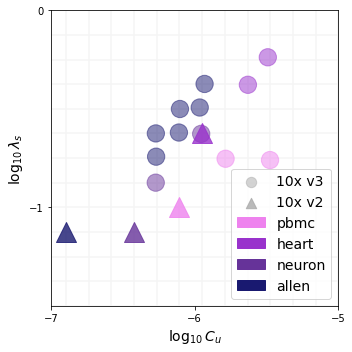

In [1088]:
fig1, ax1 = plt.subplots(figsize=(5,5))
# sr = monod.analysis.load_search_results('./fits/gg_221111_025_pbmc_celltypes_5/10x_pbmc_1k_v3_All/Bursty_Poisson_20x21/grid_scan_results_upd.res')
# plot_landscape(sr,ax1)

xl = [sr.sp.samp_lb[0],sr.sp.samp_ub[0]]
yl = [sr.sp.samp_lb[1],sr.sp.samp_ub[1]]
x=np.linspace(xl[0],xl[1],sr.sp.gridsize[0])
y=np.linspace(yl[0],yl[1],sr.sp.gridsize[1])
for i in range(sr.sp.gridsize[0]):
    plt.plot([x[i]]*2,yl,c='whitesmoke',zorder=-100)
for i in range(sr.sp.gridsize[1]):
    plt.plot(xl,[y[i]]*2,c='whitesmoke',zorder=-100)

ax1.scatter(opt_values_v3[0],opt_values_v3[1],s=300,color=opt_colors,alpha=0.5)
for k in range(4):
    ax1.scatter(opt_values_v2[0][k],opt_values_v2[1][k],s=400,
                color=aesthetics['dataset_colors'][k],alpha=0.8,marker='^')


# for legend
ax1.scatter(0,0,300,'darkgray',alpha=0.5,label='10x v3')    
ax1.scatter(0,0,300,'darkgray',alpha=0.8,marker='^',label='10x v2')
handles, labels = ax1.get_legend_handles_labels()
for k in range(4):
    legend_patch = mpatches.Patch(color=aesthetics['dataset_colors'][k], label=batch_names[k])
    handles.append(legend_patch)
ax1.set_yticks([-1,0])
ax1.set_ylim([-1.5,0])
ax1.set_xticks([-7,-6,-5])
ax1.set_xlim([-7,-5])
ax1.set_ylabel(r'$\log_{10} \lambda_s$',fontsize=aesthetics['fontsize_body_axes'])
ax1.set_xlabel(r'$\log_{10} C_u$',fontsize=aesthetics['fontsize_body_axes'])


ax1.legend(handles=handles,loc='lower right',markerscale=0.6,fontsize=aesthetics['fontsize_body_axes'])
fig1.tight_layout()
fig1.savefig('./'+figdir+'/landscape_v2.png',dpi=600)


### Supplements to 3e

Here, we show that the inferred technical parameters do produce more coherent biological parameters.

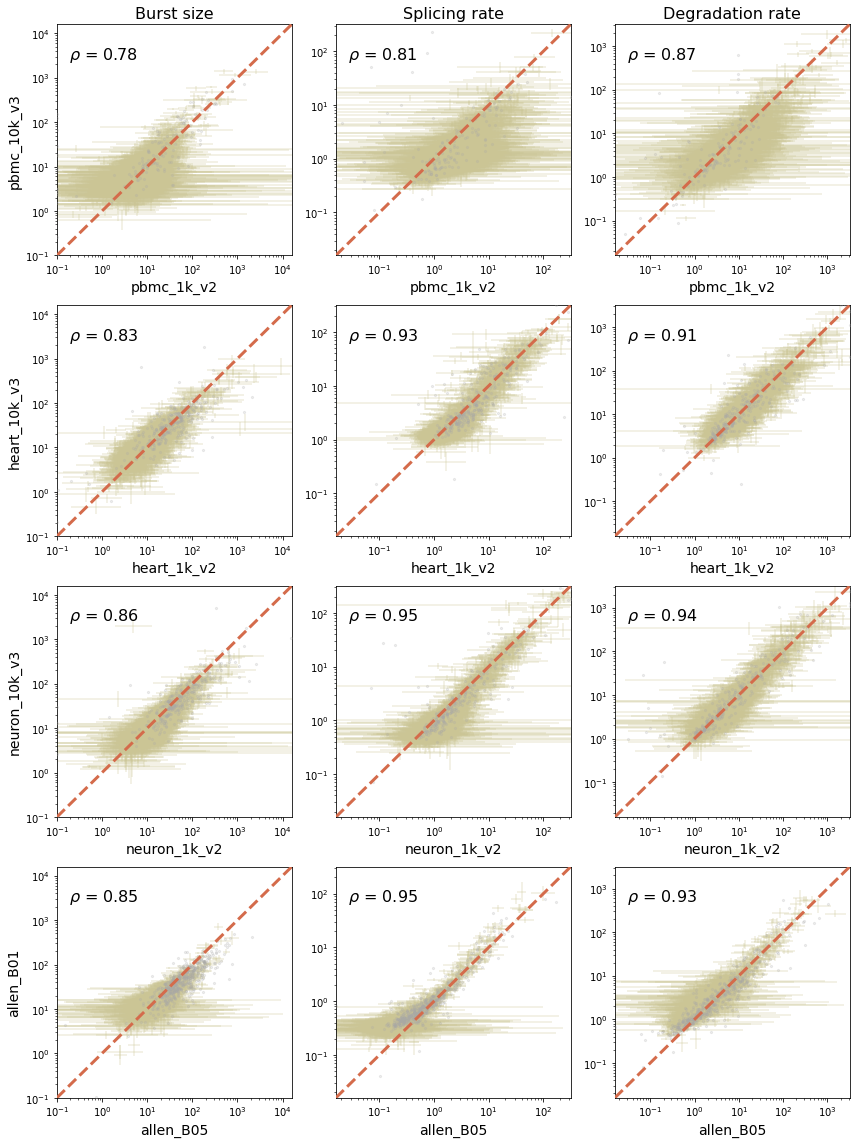

In [1158]:
n_pairs = len(batch_names)
fig1, ax1 = plt.subplots(nrows=n_pairs,ncols=3,figsize=(12,16))
for k in range(3):
    ax1[0,k].set_title(param_names[k],fontsize=aesthetics['fontsize_body_title'])

for batch_index in range(len(batch_names)):
    pair = tech_v2_replicate_pairs[batch_index]
    dataset_1 = dataset_name_list[batch_index][pair[0]]
    dataset_2 = dataset_name_list[batch_index][pair[1]]
    sr1 = monod.analysis.load_search_results('./fits/'+batch_dirs[batch_index]+'/'+dataset_1+'/Bursty_Poisson_20x21/grid_scan_results_upd.res')
    sd1 = monod.analysis.load_search_data('./fits/'+batch_dirs[batch_index]+'/'+dataset_1+'/raw.sd')
    sr2 = monod.analysis.load_search_results('./fits/'+batch_dirs[batch_index]+'/'+dataset_2+'/Bursty_Poisson_20x21/grid_scan_results_upd.res')
    sr1.set_sampling_optimum(
        np.argmin(((sr1.param_estimates[:,~sr2.rejected_genes,:] - sr2.phys_optimum[~sr2.rejected_genes])**2).sum((1,2))))
    sr1.chisquare_testing(sd1,threshold=0.01)
    plot_params_for_pair(sr1,sr2,ax1[batch_index])
    ax1[batch_index,0].set_ylabel(dataset_2,fontsize=aesthetics['fontsize_body_axes'])
    for k in range(3):
        ax1[batch_index,k].set_xlabel(dataset_1,fontsize=aesthetics['fontsize_body_axes'])

fig1.tight_layout()
fig1.savefig('./'+figdir+'/v2_parameter_correction.png',dpi=600)

# Figure 4: parameter modulation within datasets

## Panel a: comparison of parameter values between cell types

#### Sampling parameter choice: PBMC

In [1228]:
sr_arr_pbmc = [monod.analysis.load_search_results('./fits/'+pbmc_celltype_batch_dir+'/'+x+'/Bursty_Poisson_20x21/grid_scan_results_upd.res') for x in pbmc_celltypes]
sd_arr_pbmc = [monod.analysis.load_search_data('./fits/'+pbmc_celltype_batch_dir+'/'+x+'/raw.sd') for x in pbmc_celltypes]
sr_pbmc_baseline = monod.analysis.load_search_results('./fits/'+pbmc_baseline_dir+'/'+pbmc_celltype_dataset+'/Bursty_Poisson_20x21/grid_scan_results_upd.res')

In [1229]:
pbmc_celltypes

['pbmc_10k_v3_Tcells', 'pbmc_10k_v3_Monocytes', 'pbmc_10k_v3_Bcells']

In [1230]:
sr_pbmc_baseline.samp_optimum

(-5.7894736842105265, -0.75)

In [1231]:
[x.samp_optimum for x in sr_arr_pbmc]

[(-5.631578947368421, -0.75),
 (-5.7894736842105265, -1.0),
 (-5.631578947368421, -0.875)]

Here, we compare the grid fits for T cells, B cells, and monocytes, and find that the biological parameters are roughly consistent.

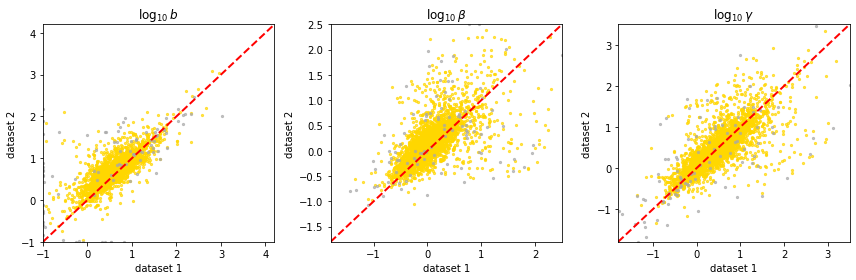

In [1232]:
monod.analysis.plot_params_for_pair(sr_arr_pbmc[0],sr_arr_pbmc[2])

Here, we compare the inferred technical noise parameters and find that they are roughly consistent, although they do not perfectly match. We make a somewhat arbitrary assumption and assume that the "best" set of parameters is the one obtained for the aggregated dataset, but strive to remind that this elides some uncertainty.

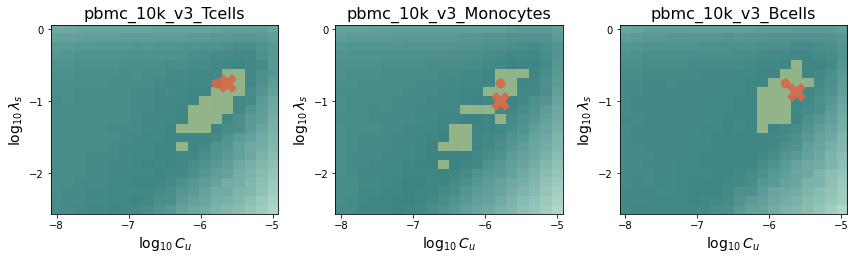

In [1233]:
fig1, ax1 = plt.subplots(nrows=1,ncols=3,figsize=(12,4))

for k in range(3):
    plot_landscape(sr_arr_pbmc[k],ax1[k])
    ax1[k].scatter(sr_arr_pbmc[k].samp_optimum[0],sr_arr_pbmc[k].samp_optimum[1],s=aesthetics['highlighted_optimum_markersize'],color=aesthetics['optimum_color'],alpha=0.95,
               marker='X')
    ax1[k].scatter(sr_pbmc_baseline.samp_optimum[0],sr_baseline.samp_optimum[1],
                   s=aesthetics['highlighted_optimum_markersize'],color=aesthetics['optimum_color'],alpha=0.95,
                   marker = '.')
    ax1[k].set_title(pbmc_celltypes[k],fontsize=aesthetics['fontsize_body_title'])
    ax1[k].set_ylabel(r'$\log_{10} \lambda_s$',fontsize=aesthetics['fontsize_body_axes'])
    ax1[k].set_xlabel(r'$\log_{10} C_u$',fontsize=aesthetics['fontsize_body_axes'])
    ax1[k].set_yticks([-2,-1,0])
    ax1[k].set_xticks([-8,-7,-6,-5])
fig1.tight_layout()
fig1.savefig('./'+figdir+'/landscape_celltypes_pbmc.png',dpi=600)

In [1234]:
for k in range(3):
    sr_arr_pbmc[k].set_sampling_optimum(sr_pbmc_baseline.samp_optimum_ind)
    _=sr_arr_pbmc[k].chisquare_testing(sd_arr_pbmc[k],threshold=0.01)

In [1648]:
def plot_marker_gene_pairs(sr_arr,pair,markers,celltype_names,ax1,colorset):
    gn = sr_arr[0].gene_names
    n_genes = len(gn)

    gf_rej = (~sr_arr[pair[1]].rejected_genes) & (~sr_arr[pair[0]].rejected_genes)
    fc_par = (sr_arr[pair[1]].phys_optimum-sr_arr[pair[0]].phys_optimum)/np.log10(2)

    gf_mark_ = [np.where(gn == x)[0][0] for x in markers[pair[0]]]
    gf_mark_pop_0 = np.zeros(n_genes,dtype=bool)
    gf_mark_pop_0[gf_mark_] = True


    gf_mark_ = [np.where(gn == x)[0][0] for x in markers[pair[1]]]
    gf_mark_pop_1 = np.zeros(n_genes,dtype=bool)
    gf_mark_pop_1[gf_mark_] = True
    
    
    for k in range(3):
        x = 10**sr_arr[pair[0]].phys_optimum[:,k]
        y = 10**sr_arr[pair[1]].phys_optimum[:,k]
        ax1[k].scatter(x[gf_rej],y[gf_rej],
                       s=aesthetics['celltype_diffs_ms'],
                       c=aesthetics['celltype_diffs_gene_color'],
                       alpha=aesthetics['celltype_diffs_gene_alpha'])
        ax1[k].scatter(x[gf_mark_pop_0],y[gf_mark_pop_0],
                       s=aesthetics['celltype_marker_ms'],
                       c=aesthetics[colorset][pair[0]],
                       alpha=aesthetics['celltype_marker_alpha'])
        ax1[k].scatter(x[gf_mark_pop_1],y[gf_mark_pop_1],
                       s=aesthetics['celltype_marker_ms'],
                       c=aesthetics[colorset][pair[1]],
                       alpha=aesthetics['celltype_marker_alpha'])
        ax1[k].set_xlabel(param_names[k]+' in '+celltype_names[pair[0]],fontsize=aesthetics['fontsize_body_axes'])
        ax1[k].set_ylabel(param_names[k]+' in '+celltype_names[pair[1]],fontsize=aesthetics['fontsize_body_axes'])
        xl = [x.min(),y.max()]        
        ax1[k].plot(xl,xl,'--',color=aesthetics['identity_line_color'],linewidth=aesthetics['identity_lw'],zorder=200)
        ax1[k].set_xscale('log')
        ax1[k].set_yscale('log')

In Fig. 4a, we compare the parameters obtained for distinct cell types and find that they concord -- with the dramatic exception of certain marker genes.

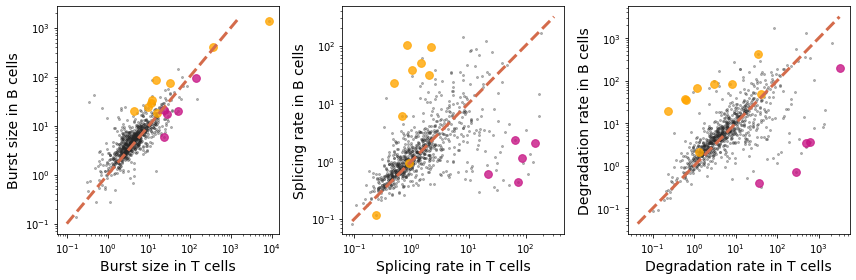

In [1649]:
pbmc_pairs = [[0,1],[0,2],[1,2]]
pair = pbmc_pairs[1]
fig1,ax1 = plt.subplots(1,3,figsize=(12,4))
plot_marker_gene_pairs(sr_arr_pbmc,pair,pbmc_markers,pbmc_celltype_names_labels,ax1,'celltype_colors_pbmc')
fig1.tight_layout()
fig1.savefig('./'+figdir+'/celltype_diffs_pbmc_subset.png',dpi=600)

### Supplements to 4a

#### PBMC

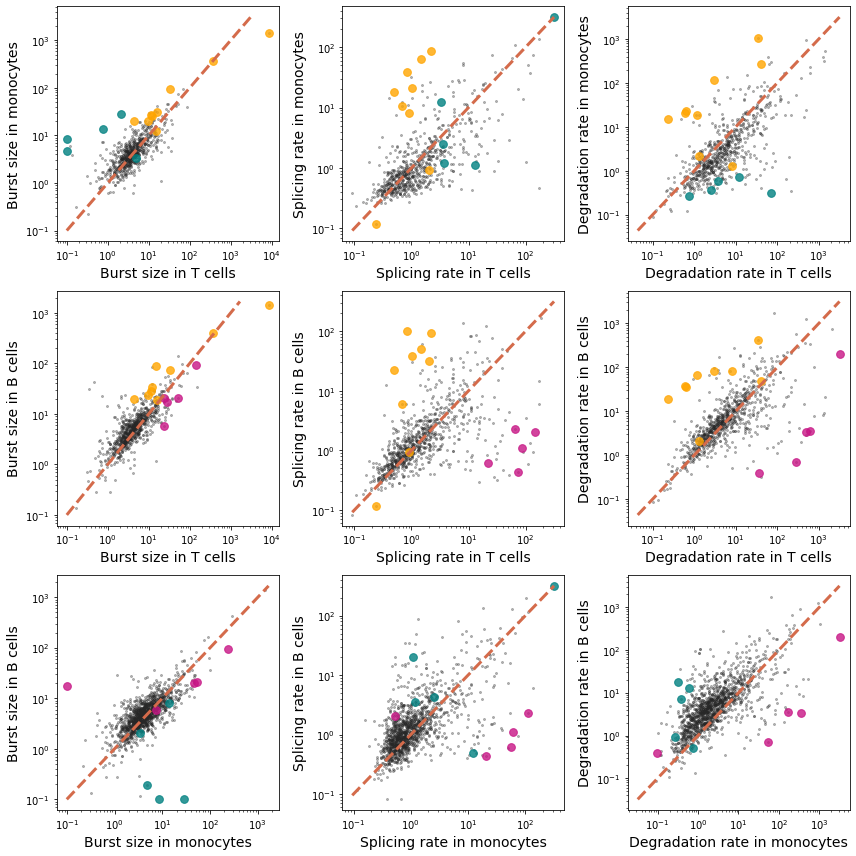

In [1650]:
fig1,ax1 = plt.subplots(3,3,figsize=(12,12))
for pair_index,pair in enumerate(pbmc_pairs):
    plot_marker_gene_pairs(sr_arr_pbmc,pair,pbmc_markers,pbmc_celltype_names_labels,ax1[pair_index],'celltype_colors_pbmc')
fig1.tight_layout()
fig1.savefig('./'+figdir+'/celltype_diffs_pbmc.png',dpi=600)

### Allen

#### Sampling parameter choice: Allen

Here, we select a "reasonable" average Allen sampling parameter set to run the cell type datasets without doing a grid scan.

In [1651]:
sr_baseline_arr = [monod.analysis.load_search_results('./fits/'+batch_dirs[3]+'/'+x+'/Bursty_Poisson_20x21/grid_scan_results_upd.res') for x in dataset_v3_list[3]]
samp_optima = np.asarray([x.samp_optimum for x in sr_baseline_arr])
samp_optimum_inferred = samp_optima.mean(0)
print(samp_optimum_inferred)

[-6.10526316 -0.5625    ]


In [1652]:
pair = [0,1]

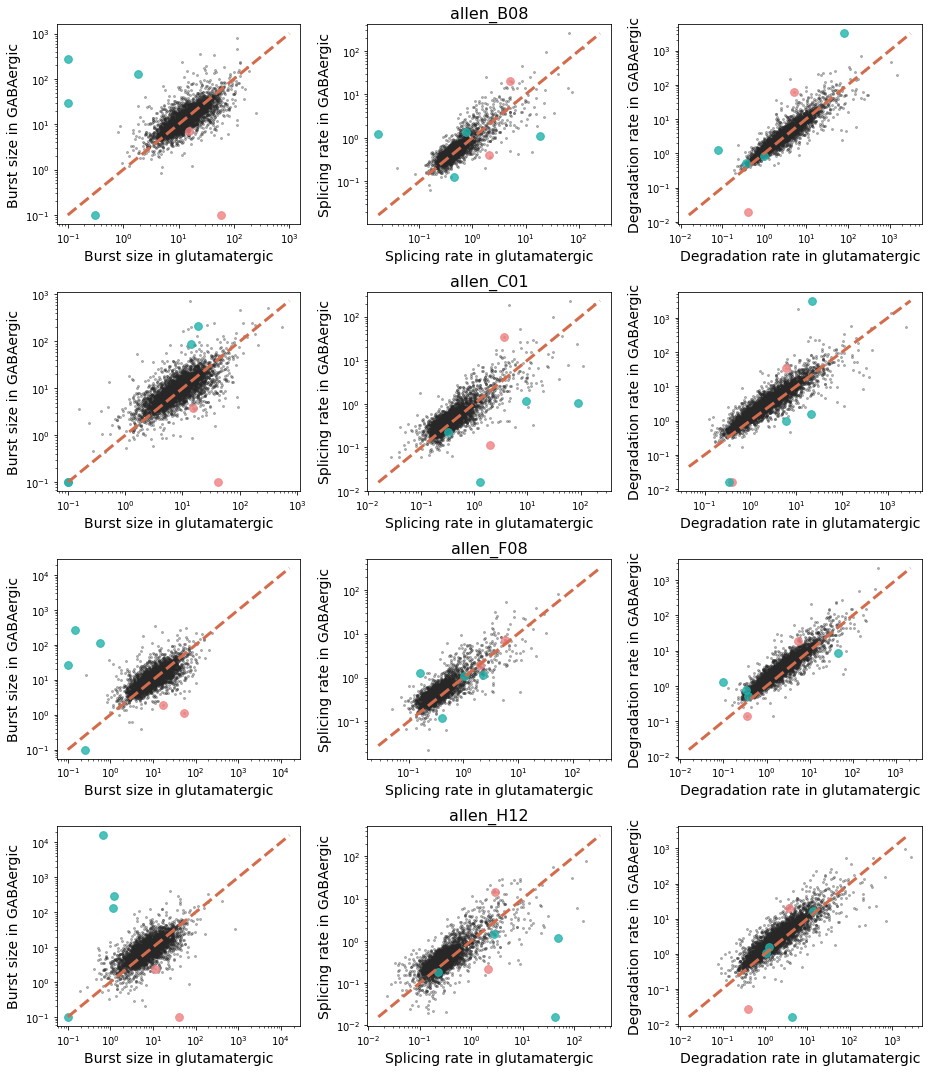

In [1653]:
fig1,ax1 = plt.subplots(4,3,figsize=(13,15))
for k,celltype_datasets in enumerate(allen_celltypes):
    sr_arr_allen = [monod.analysis.load_search_results('./fits/'+allen_celltype_batch_dir+'/'+x+'/Bursty_Poisson_1x1/grid_scan_results_upd.res') for x in celltype_datasets]
    plot_marker_gene_pairs(sr_arr_allen,pair,allen_markers,allen_celltype_names_labels,ax1[k],'celltype_colors_allen')
    ax1[k,1].set_title(allen_celltype_datasets[k],fontsize=aesthetics['fontsize_body_title'])
fig1.tight_layout()
fig1.savefig('./'+figdir+'/celltype_diffs_allen.png',dpi=600)

## Panel b: relationships between modulation patterns

In [1654]:
def plot_marker_gene_pair_differences(sr_arr,pair,markers,celltype_names,ax1,colorset,omit_title=False):
    gn = sr_arr[0].gene_names
    n_genes = len(gn)

    gf_rej = (~sr_arr[pair[1]].rejected_genes) & (~sr_arr[pair[0]].rejected_genes)

    gf_mark_ = [np.where(gn == x)[0][0] for x in markers[pair[0]]]
    gf_mark_pop_0 = np.zeros(n_genes,dtype=bool)
    gf_mark_pop_0[gf_mark_] = True


    gf_mark_ = [np.where(gn == x)[0][0] for x in markers[pair[1]]]
    gf_mark_pop_1 = np.zeros(n_genes,dtype=bool)
    gf_mark_pop_1[gf_mark_] = True
    
    parameter_pairs = [[0,1],[0,2],[1,2]]
    for k,param_pair in enumerate(parameter_pairs):
        x = (sr_arr[pair[1]].phys_optimum[:,param_pair[0]] - sr_arr[pair[0]].phys_optimum[:,param_pair[0]])/np.log10(2)
        y = (sr_arr[pair[1]].phys_optimum[:,param_pair[1]] - sr_arr[pair[0]].phys_optimum[:,param_pair[1]])/np.log10(2)
        ax1[k].scatter(x[gf_rej],y[gf_rej],
                       s=aesthetics['celltype_diffs_ms'],
                       c=aesthetics['celltype_diffs_gene_color'],
                       alpha=aesthetics['celltype_diffs_gene_alpha'])
        ax1[k].scatter(x[gf_mark_pop_0],y[gf_mark_pop_0],
                       s=aesthetics['celltype_marker_ms'],
                       c=aesthetics[colorset][pair[0]],
                       alpha=aesthetics['celltype_marker_alpha'])
        ax1[k].scatter(x[gf_mark_pop_1],y[gf_mark_pop_1],
                       s=aesthetics['celltype_marker_ms'],
                       c=aesthetics[colorset][pair[1]],
                       alpha=aesthetics['celltype_marker_alpha'])
        ax1[k].set_xlabel(r'$\log_2$FC ('+param_names[param_pair[0]].lower()+')',fontsize=aesthetics['fontsize_body_axes'])
        ax1[k].set_ylabel(r'$\log_2$FC ('+param_names[param_pair[1]].lower()+')',fontsize=aesthetics['fontsize_body_axes'])
        xl = [x.min(),y.max()]        
        ax1[k].plot(xl,xl,'--',color=aesthetics['identity_line_color'],linewidth=aesthetics['identity_lw'],zorder=200)
        rho_ = np.corrcoef(x[gf_rej],y[gf_rej])[0,1]
        ax1[k].text(.05,.85,r'$\rho$ = {:.2f}'.format(rho_),fontsize=aesthetics['fontsize_body_title'],transform=ax1[k].transAxes)
    if not omit_title:
        ax1[1].set_title('Change from {} to {}'.format(celltype_names[pair[0]],celltype_names[pair[1]]),
                     fontsize=aesthetics['fontsize_body_title'])

In Fig. 4b, we inspect the patterns of parameter co-modulation between cell types, and find that the change in splicing rate is highly correlated to change in degradation rate. This suggests that both are more reasonably attributable to the *burst frequency*, which sets the units for these rates.

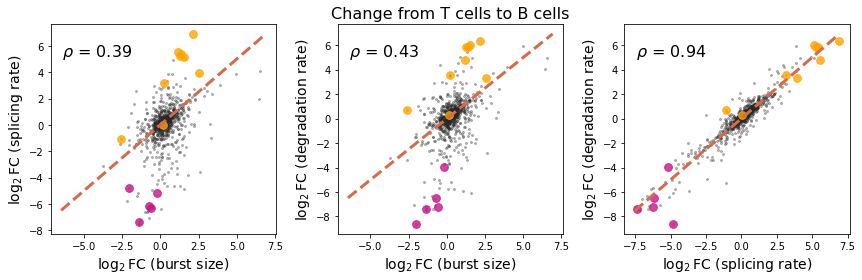

In [1655]:
pbmc_pairs = [[0,1],[0,2],[1,2]]
pair = pbmc_pairs[1]
fig1,ax1 = plt.subplots(1,3,figsize=(12,4))
plot_marker_gene_pair_differences(sr_arr_pbmc,pair,pbmc_markers,pbmc_celltype_names_labels,ax1,'celltype_colors_pbmc')
fig1.tight_layout()
fig1.savefig('./'+figdir+'/celltype_param_covar_pbmc_subset.png',dpi=600)

### Supplements to 4b

#### PBMC

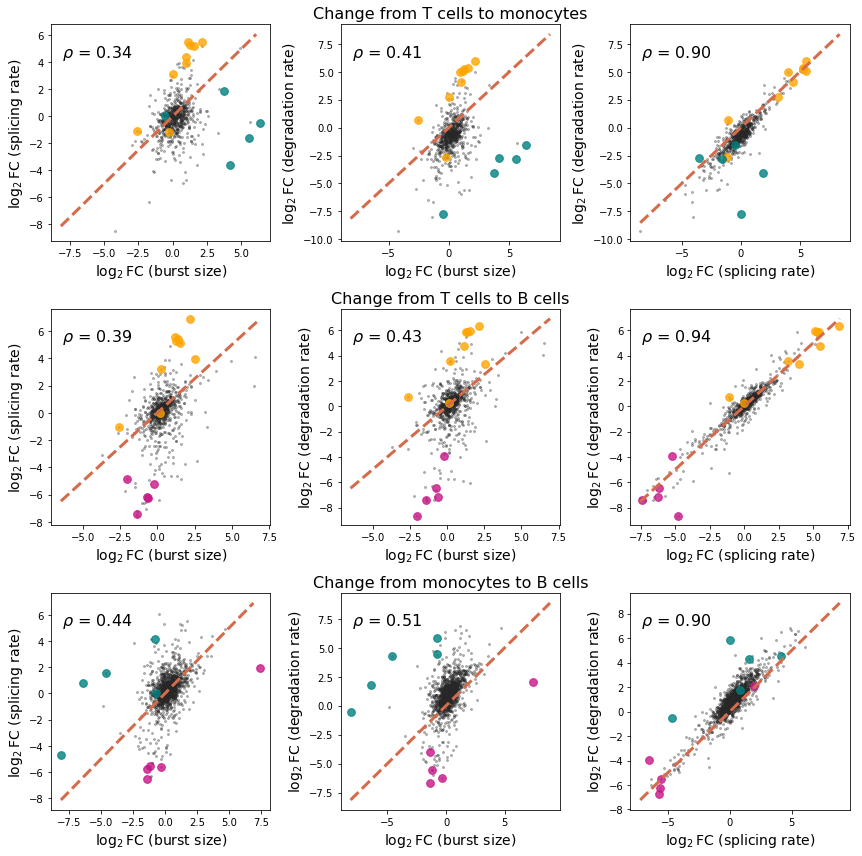

In [1656]:
fig1,ax1 = plt.subplots(3,3,figsize=(12,12))
for pair_index,pair in enumerate(pbmc_pairs):
    plot_marker_gene_pair_differences(sr_arr_pbmc,pair,pbmc_markers,pbmc_celltype_names_labels,ax1[pair_index],'celltype_colors_pbmc')
fig1.tight_layout()
fig1.savefig('./'+figdir+'/celltype_param_covar_pbmc.png',dpi=600)

#### Allen

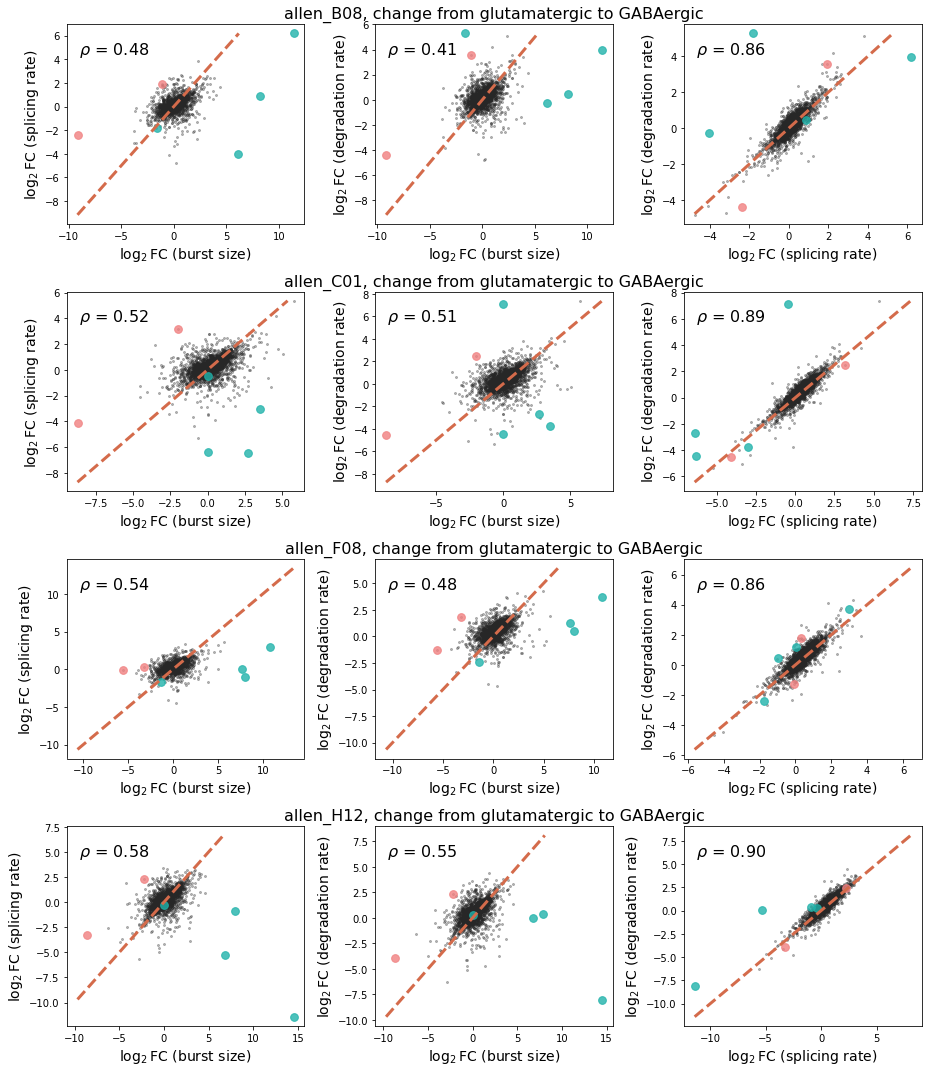

In [1657]:
fig1,ax1 = plt.subplots(4,3,figsize=(13,15))
pair = [0,1]
for k,celltype_datasets in enumerate(allen_celltypes):
    sr_arr_allen = [monod.analysis.load_search_results('./fits/'+allen_celltype_batch_dir+'/'+x+'/Bursty_Poisson_1x1/grid_scan_results_upd.res') for x in celltype_datasets]
    plot_marker_gene_pair_differences(sr_arr_allen,pair,allen_markers,allen_celltype_names_labels,ax1[k],'celltype_colors_allen',omit_title=True)
    ax1[k,1].set_title(allen_celltype_datasets[k] + ', change from {} to {}'.format(\
                        allen_celltype_names_labels[0],allen_celltype_names_labels[1]),fontsize=aesthetics['fontsize_body_title'])
fig1.tight_layout()
fig1.savefig('./'+figdir+'/celltype_param_covar_allen.png',dpi=600)


## Panel c: Burst size and frequency modulation as explanatory mechanisms

In [1766]:
def plot_marker_gene_bs_k_diffs(sr_arr,pair,markers,celltype_names,ax1,colorset):
    gn = sr_arr[0].gene_names
    n_genes = len(gn)

    gf_rej = (~sr_arr[pair[1]].rejected_genes) & (~sr_arr[pair[0]].rejected_genes)
    fc_par = (sr_arr[pair[1]].phys_optimum-sr_arr[pair[0]].phys_optimum)/np.log10(2)

    gf_mark_ = [np.where(gn == x)[0][0] for x in markers[pair[0]]]
    gf_mark_pop_0 = np.zeros(n_genes,dtype=bool)
    gf_mark_pop_0[gf_mark_] = True


    gf_mark_ = [np.where(gn == x)[0][0] for x in markers[pair[1]]]
    gf_mark_pop_1 = np.zeros(n_genes,dtype=bool)
    gf_mark_pop_1[gf_mark_] = True
    
    x = (sr_arr[pair[1]].phys_optimum[:,0] - sr_arr[pair[0]].phys_optimum[:,0])/np.log10(2)
    y = -(sr_arr[pair[1]].phys_optimum[:,1] - sr_arr[pair[0]].phys_optimum[:,1])/np.log10(2)

#     print(x[gf_mark_pop_0]+y[gf_mark_pop_0])
#     print(x[gf_mark_pop_1]+y[gf_mark_pop_1])
    ax1.scatter(x[gf_rej],y[gf_rej],
                   s=aesthetics['celltype_diffs_ms'],
                   c=aesthetics['celltype_diffs_gene_color'],
                   alpha=aesthetics['celltype_diffs_gene_alpha'])
    ax1.scatter(x[gf_mark_pop_0],y[gf_mark_pop_0],
                   s=aesthetics['celltype_marker_ms'],
                   c=aesthetics[colorset][pair[0]],
                   alpha=aesthetics['celltype_marker_alpha'])
    ax1.scatter(x[gf_mark_pop_1],y[gf_mark_pop_1],
                   s=aesthetics['celltype_marker_ms'],
                   c=aesthetics[colorset][pair[1]],
                   alpha=aesthetics['celltype_marker_alpha'])
    ax1.set_xlabel(r'$\log_2$FC (burst size)',fontsize=aesthetics['fontsize_body_axes'])
    ax1.set_ylabel(r'$\log_2$FC (burst frequency)',fontsize=aesthetics['fontsize_body_axes'])
    
    xl = np.asarray([-4,4])
#     ax1.plot(xl,-xl,'-',color=aesthetics['partition_line_color'],linewidth=aesthetics['identity_lw'],zorder=200,alpha=0.8)
    ax1.plot(xl,-xl,'-',color=aesthetics['partition_line_color'],linewidth=4,zorder=200)
#     ax1.set_xlim([-2.5,2.5])
#     ax1.set_ylim([-2.5,2.5])
#     ax1.set_xlim([-8,8])
#     ax1.set_ylim([-8,8])
    ax1.axis('equal')
    ax1.set_title('Change from\n{} to {}'.format(celltype_names[pair[0]],celltype_names[pair[1]]),
                     fontsize=aesthetics['fontsize_body_title'])

In Fig. 4c, we take this finding to its logical conclusion and summarize the differences between cell types in terms of differences in burst sizes and frequencies. For example, the difference between B and T cells appears to mostly be attributable to burst frequency modulation.

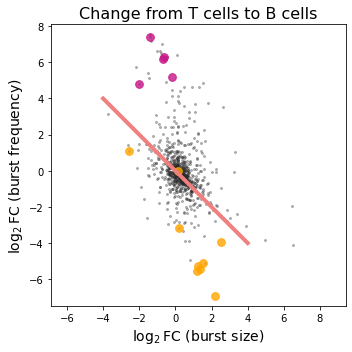

In [1659]:
pbmc_pairs = [[0,1],[0,2],[1,2]]
pair = pbmc_pairs[1]
fig1,ax1 = plt.subplots(1,1,figsize=(5,5))
plot_marker_gene_bs_k_diffs(sr_arr_pbmc,pair,pbmc_markers,pbmc_celltype_names_labels,ax1,'celltype_colors_pbmc')
fig1.tight_layout()
fig1.savefig('./'+figdir+'/celltype_param_bs_k_pbmc_subset.png',dpi=600)

### Supplements to 4c

#### PBMC

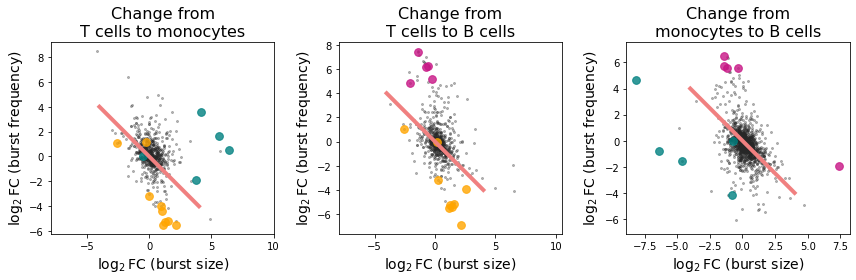

In [1767]:
fig1,ax1 = plt.subplots(1,3,figsize=(12,4))
for pair_index,pair in enumerate(pbmc_pairs):
    plot_marker_gene_bs_k_diffs(sr_arr_pbmc,pair,pbmc_markers,pbmc_celltype_names_labels,ax1[pair_index],'celltype_colors_pbmc')
fig1.tight_layout()
fig1.savefig('./'+figdir+'/celltype_param_bs_k_pbmc.png',dpi=600)

#### Allen

In [1661]:
allen_markers

[['Slc17a7', 'Slc17a6'], ['Gad1', 'Gad2', 'Slc32a1', 'Slc6a5']]

Here, we inspect the GABAergic marker Slc6a5, which actually turns out to not be a very good marker: it is essentially absent. This could be due to some reference inconsistency.

In [1662]:
pair = [0,1]

for k,celltype_datasets in enumerate(allen_celltypes):
    print(allen_celltype_datasets[k])
    sd_arr_allen = [monod.analysis.load_search_data('./fits/'+allen_celltype_batch_dir+'/'+x+'/raw.sd') for x in celltype_datasets]
    gn = sd_arr_allen[0].gene_names
    
    gf_mark_ = [np.where(gn == x)[0][0] for x in allen_markers[pair[0]]]
    gf_mark_glu = np.zeros(n_genes,dtype=bool)
    gf_mark_glu[gf_mark_] = True

    gf_mark_ = [np.where(gn == x)[0][0] for x in allen_markers[pair[1]]]
    gf_mark_gaba = np.zeros(n_genes,dtype=bool)
    gf_mark_gaba[gf_mark_] = True
    
    print(f'\tGlu marker mean in Glu: {sd_arr_allen[0].layers[1,gf_mark_glu].mean(1).round(1)}')
    print(f'\tGlu marker mean in GABA: {sd_arr_allen[1].layers[1,gf_mark_glu].mean(1).round(1)}')
    print(f'\tGABA marker mean in Glu: {sd_arr_allen[0].layers[1,gf_mark_gaba].mean(1).round(1)}')
    print(f'\tGABA marker mean in GABA: {sd_arr_allen[1].layers[1,gf_mark_gaba].mean(1).round(1)}')


allen_B08
	Glu marker mean in Glu: [ 0.8 38.3]
	Glu marker mean in GABA: [0.  1.6]
	GABA marker mean in Glu: [0.5 0.1 0.5 0. ]
	GABA marker mean in GABA: [61.9 15.9 42.1  0. ]
allen_C01
	Glu marker mean in Glu: [ 0.7 29.6]
	Glu marker mean in GABA: [0.  1.6]
	GABA marker mean in Glu: [0.3 0.1 0.4 0. ]
	GABA marker mean in GABA: [38.  10.1 25.8  0. ]
allen_F08
	Glu marker mean in Glu: [ 0.9 41.4]
	Glu marker mean in GABA: [0.  2.1]
	GABA marker mean in Glu: [0.4 0.1 0.5 0. ]
	GABA marker mean in GABA: [58.2 13.2 41.4  0. ]
allen_H12
	Glu marker mean in Glu: [ 0.8 27.8]
	Glu marker mean in GABA: [0. 1.]
	GABA marker mean in Glu: [0.2 0.  0.3 0. ]
	GABA marker mean in GABA: [51.4  9.3 34.4  0. ]


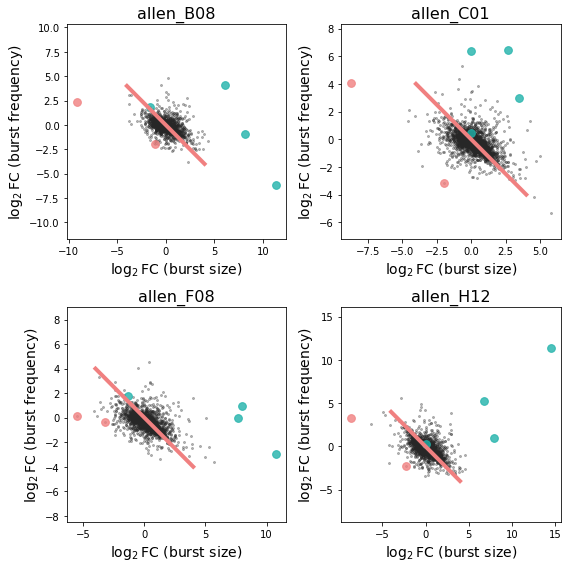

In [1663]:
fig1,ax1 = plt.subplots(2,2,figsize=(8,8))
pair = [0,1]
for k,celltype_datasets in enumerate(allen_celltypes):
    axloc = np.unravel_index(k,(2,2))
    sr_arr_allen = [monod.analysis.load_search_results('./fits/'+allen_celltype_batch_dir+'/'+x+'/Bursty_Poisson_1x1/grid_scan_results_upd.res') for x in celltype_datasets]
    plot_marker_gene_bs_k_diffs(sr_arr_allen,pair,allen_markers,allen_celltype_names_labels,ax1[axloc],'celltype_colors_allen')
    ax1[axloc].set_title(allen_celltype_datasets[k] ,fontsize=aesthetics['fontsize_body_title'])
fig1.tight_layout()
fig1.savefig('./'+figdir+'/celltype_param_bs_k_allen.png',dpi=600)


## Panel 4d: Statistical testing of differences between neural cell types

Here, we set up the stage for doing statistical testing between Allen cell type populations. Ostensibly, the cell types have fairly consistent parameter values, but they have some biases, which are possibly attributable to uncertainty and variation in technical noise parameters.

The best way to treat this issue is unclear, but to "balance" the $t$-test, we do a simple round of de-biasing.

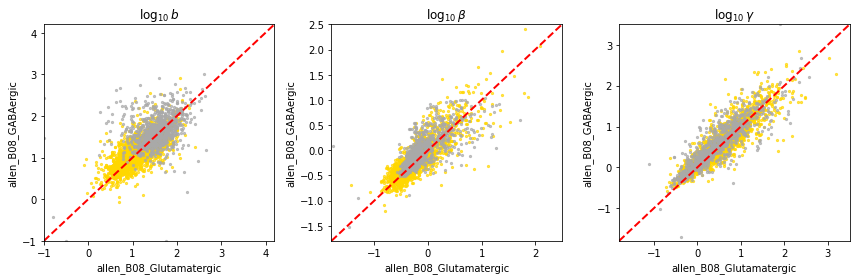

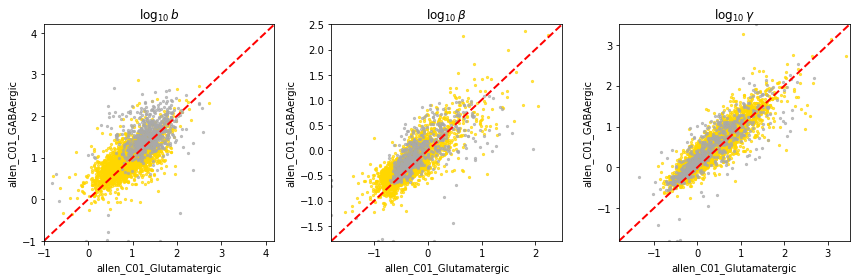

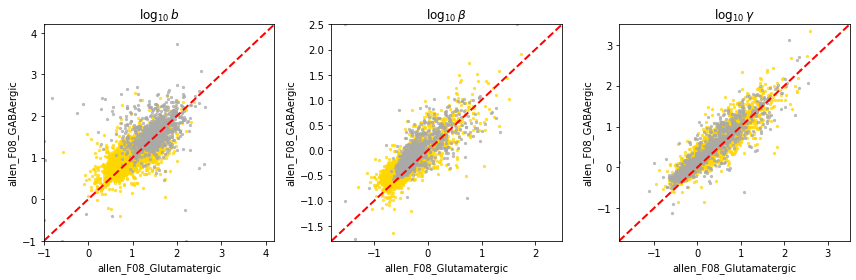

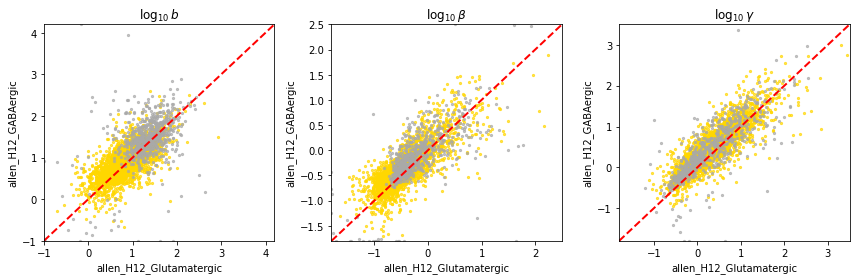

In [1664]:
par_vals_uncorrected = []
gf = []
for k,celltype_datasets in enumerate(allen_celltypes):
    sr_arr_allen = [monod.analysis.load_search_results('./fits/'+allen_celltype_batch_dir+'/'+x+'/Bursty_Poisson_1x1/grid_scan_results_upd.res') for x in celltype_datasets]
    par_vals_uncorrected.append([x.phys_optimum for x in sr_arr_allen])
    gf.append([~x.rejected_genes for x in sr_arr_allen])
    monod.analysis.plot_params_for_pair(sr_arr_allen[0],sr_arr_allen[1],xlabel=celltype_datasets[0],ylabel=celltype_datasets[1])
par_vals_uncorrected = np.asarray(par_vals_uncorrected)
gf = np.asarray(gf)

In [1665]:
offsets = []
par_vals = np.copy(par_vals_uncorrected)
n_datasets = len(allen_celltypes)
for k in range(3):
    m1 = par_vals_uncorrected[0,0,:,k]
    for j in range(1,n_datasets):
        m2 = par_vals_uncorrected[j,0,:,k]
        offset = monod.analysis.diffexp_fpi(m1,m2,param_names[k],viz=False)[1]
        par_vals[j,0,:,k] -= offset
    for j in range(n_datasets):
        m2 = par_vals_uncorrected[j,1,:,k]
        offset = monod.analysis.diffexp_fpi(m1,m2,param_names[k],viz=False)[1]
        par_vals[j,1,:,k] -= offset


Here, we see that the debiased parameters are more consistent with the identity line.

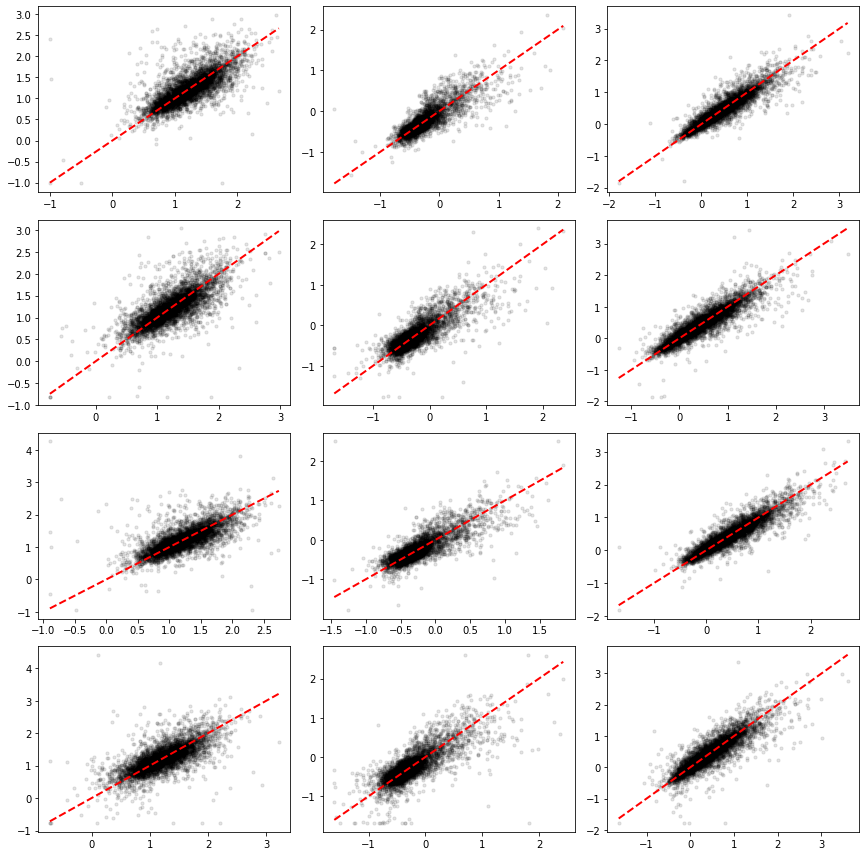

In [1666]:
fig1,ax1 = plt.subplots(4,3,figsize=(12,12))
for d in range(n_datasets):
    for k in range(3):
        x=par_vals[d,0,:,k]
        y=par_vals[d,1,:,k]
        xl = [min(x),max(x)]
        ax1[d,k].scatter(x,y,10,'k',alpha=0.1) 

        ax1[d,k].plot(xl,xl,'r--',linewidth=2)
fig1.tight_layout()


In [1668]:
n_genes = par_vals.shape[2]

Here, we run a $t$-test on the parameter values. This will occasionally throw errors, because we have *at most* $n=4$ samples per cell type: we throw out genes that fail goodness-of-fit.

In [1669]:
p_par = np.zeros((n_genes,3))
for k in range(3):
    for j in range(n_genes):
        p_par[j,k] = scipy.stats.ttest_ind(par_vals[gf[:,0,j],0,j,k],par_vals[gf[:,1,j],1,j,k],equal_var=False)[1]


/tmp/ipykernel_3463100/2868503142.py:4: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  p_par[j,k] = scipy.stats.ttest_ind(par_vals[gf[:,0,j],0,j,k],par_vals[gf[:,1,j],1,j,k],equal_var=False)[1]
/home/ggorin/miniconda3/lib/python3.9/site-packages/scipy/stats/_stats_py.py:1250: RuntimeWarning: divide by zero encountered in divide
  var *= np.divide(n, n-ddof)  # to avoid error on division by zero
/home/ggorin/miniconda3/lib/python3.9/site-packages/scipy/stats/_stats_py.py:1250: RuntimeWarning: invalid value encountered in double_scalars
  var *= np.divide(n, n-ddof)  # to avoid error on division by zero


In [1670]:
fc_par = ((par_vals[:,1,:,:]-par_vals[:,0,:,:])/np.log10(2)).mean(0)

In Fig. 4d, we illustrate the genes that have been found to have consistent parameter differences between glutamatergic and GABAergic cell types.

<>:31: DeprecationWarning: invalid escape sequence \l
<>:31: DeprecationWarning: invalid escape sequence \l
/tmp/ipykernel_3463100/338831265.py:31: DeprecationWarning: invalid escape sequence \l
  ax1[k].set_xlabel('Average ' + param_names[k].lower()+' $\log_2$ FC',fontsize=aesthetics['fontsize_body_axes'])


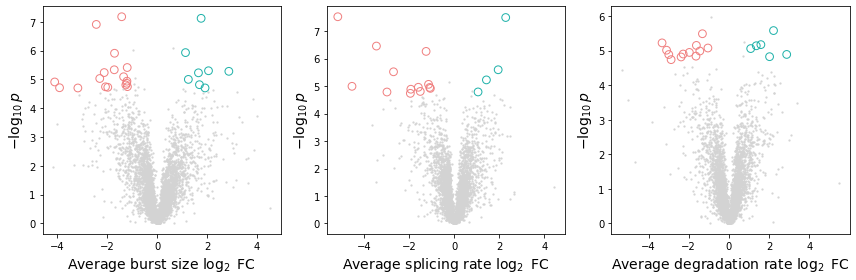

In [1708]:
fig1,ax1 = plt.subplots(1,3,figsize=(12,4))
dr_par_multi = np.zeros((n_genes,3),dtype=bool)
pval_thr = 0.1/n_genes
gf_gaba_all = []
gf_glu_all = []
for k in range(3):
    fc_d = fc_par_multi[:,k]
    gf_pval = p_par[:,k]<pval_thr
    
    gf_fc_gaba = fc_d>1
    gf_fc_glu = fc_d<-1
    gf_gaba = gf_pval & gf_fc_gaba
    gf_glu = gf_pval & gf_fc_glu
    
    gf_gaba_all.append(gf_gaba)
    gf_glu_all.append(gf_glu)
    
#     dr_par_multi[:,k] = gf
    gf_notselected = (~ gf_gaba) & (~ gf_glu)
    
    logp_par = -np.log10(p_par[:,k])
    ax1[k].scatter(fc_d[gf_gaba],logp_par[gf_gaba],color=aesthetics['celltype_colors_allen'][1],
                   s=aesthetics['celltype_marker_ms'],
                   alpha=1,facecolors='none')
    ax1[k].scatter(fc_d[gf_glu],logp_par[gf_glu],color=aesthetics['celltype_colors_allen'][0],
                   s=aesthetics['celltype_marker_ms'],
                   alpha=1,facecolors='none')
    ax1[k].scatter(fc_d[gf_notselected],logp_par[gf_notselected],color=aesthetics['omitted_color'],\
                   s=aesthetics['omitted_markersize_body'],alpha=0.8)
    ax1[k].set_ylabel(r'$-\log_{10} p$',fontsize=aesthetics['fontsize_body_axes'])
    ax1[k].set_xlabel('Average ' + param_names[k].lower()+' $\log_2$ FC',fontsize=aesthetics['fontsize_body_axes'])
fig1.tight_layout()
fig1.savefig('./'+figdir+'/volcano.png',dpi=600)

### Supplements to 4d

In [1824]:
def compare_gene_distributions(
    sr_arr,
    sd_arr,
    sz=(5, 5),
    figsize=(10, 10),
    marg="mature",
    logscale=None,
    title=True,
    genes_to_plot=None,
):
    if logscale is None:
        if marg == "joint":
            logscale = True
        else:
            logscale = False
    (nrows, ncols) = sz

    fig1, ax1 = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize)

    nax = np.prod(sz)
    if genes_to_plot is None:
        genes_to_plot = np.arange(nax)

    genes_to_plot = np.asarray(genes_to_plot)
    if genes_to_plot.dtype == bool:
        gtp_temp = np.arange(sr_arr[0].n_genes)
        genes_to_plot = gtp_temp[genes_to_plot]

    number_of_genes_to_plot = len(genes_to_plot)
    if number_of_genes_to_plot > sr_arr[0].n_genes:
        number_of_genes_to_plot = sr_arr[0].n_genes
        genes_to_plot = genes_to_plot[: self.n_genes]
    if number_of_genes_to_plot > nax:
        number_of_genes_to_plot = nax
        genes_to_plot = genes_to_plot[:nax]

    j_ = 0
    for i_ in genes_to_plot:
        axloc = np.unravel_index(j_, sz) if (sz[0] > 1 and sz[1] > 1) else j_
        xlim = 1
#         print(sd_arr[0].gene_names[i_])
        for j in range(len(sr_arr)):
            lm = np.copy(sd_arr[j].M[:, i_])
            if marg=='mature':
                latex_str =  r' $\mu_s$: '
                moment_key = 'S_mean'
            elif marg =='nascent':
                latex_str =  r' $\mu_u$: '
                moment_key = 'U_mean'
            textstr = allen_celltype_names[j][:4] +latex_str+ '{:.2f}'.format(sd_arr[j].moments[i_][moment_key])
            ax1[axloc].text(.3,.8-j*0.2,textstr,transform=ax1[axloc].transAxes,fontsize=15)
#             ax1[axloc].text(.1,.7,textstr,transform=ax1[axloc].transAxes,fontsize=15)
#             print(sd_arr[j].moments[i_])
            if marg == "mature":
                lm[0] = 1
            if marg == "nascent":
                lm[1] = 1
            xlim = np.max([max(lm), xlim])
            samp = (
                None
                if (sr_arr[j].model.seq_model == "None")
                else sr_arr[j].regressor_optimum[i_]
            )
            Pa = np.squeeze(
                sr_arr[j].model.eval_model_pss(sr_arr[j].phys_optimum[i_], lm, samp)
            )

            if marg == "joint":
                log.error("Potentially implement this later...")
                raise ValueError("Cannot compare two 2D histograms!")
            else:
                monod.inference.plot_hist_and_fit(
                    ax1[axloc],
                    sd_arr[j],
                    i_,
                    Pa,
                    marg,
                    facealpha=0.5,
                    facecolor=aesthetics['celltype_colors_allen'][j],
                    fitcolor=aesthetics['celltype_colors_allen'][j],
                )
        ax1[axloc].set_xlim([-0.5, xlim - 8])
        if logscale:
            ax1[axloc].set_yscale("log")
        if title:
            ax1[axloc].set_title(sr_arr[0].gene_names[i_], fontdict={"fontsize": aesthetics['fontsize_body_title']})

        ax1[axloc].set_xticks([])
        ax1[axloc].set_yticks([])

        j_ += 1
    fig1.tight_layout(pad=0.02)
    return fig1,ax1

Here, we plot the raw data and fits for some interesting genes.

In [1761]:
for x in gn[gf_gaba_all[0]]:
    print(x)

Fam174a
Arhgef28
Rgmb
Dpysl3
Bach2
Dennd2a
Bckdhb
Ap1s2


In [1762]:
for x in gn[gf_glu_all[0]]:
    print(x)

Rnf152
2010300C02Rik
Pip5k1c
Nin
Rap2a
Fzd3
Nr4a1
Dnajc21
Igsf21
Rasgef1a
Igf1r
Stx4a
Rnf169
Mast3
Nectin1
Scg3
Mras


In [1675]:
sd_arr_allen = [monod.analysis.load_search_data('./fits/'+allen_celltype_batch_dir+'/'+x+'/raw.sd') for x in celltype_datasets]

In [1676]:
celltype_datasets

['allen_H12_Glutamatergic', 'allen_H12_GABAergic']

#### Burst size-modulated genes

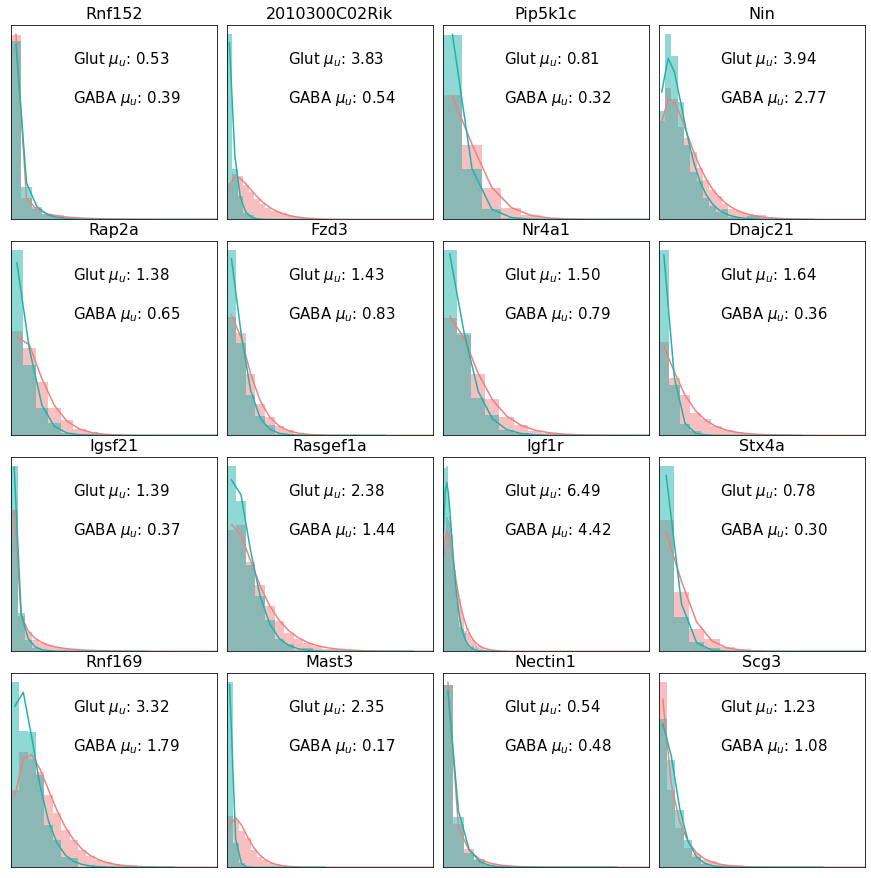

In [1825]:
fig1,ax1=compare_gene_distributions(sr_arr_allen,sd_arr_allen,genes_to_plot=gf_glu_all[0],marg='nascent',
                          sz=(4,4),figsize=(12,12))
fig1.savefig('./'+figdir+'/bs_modulation_H12_nascent.png',dpi=600)

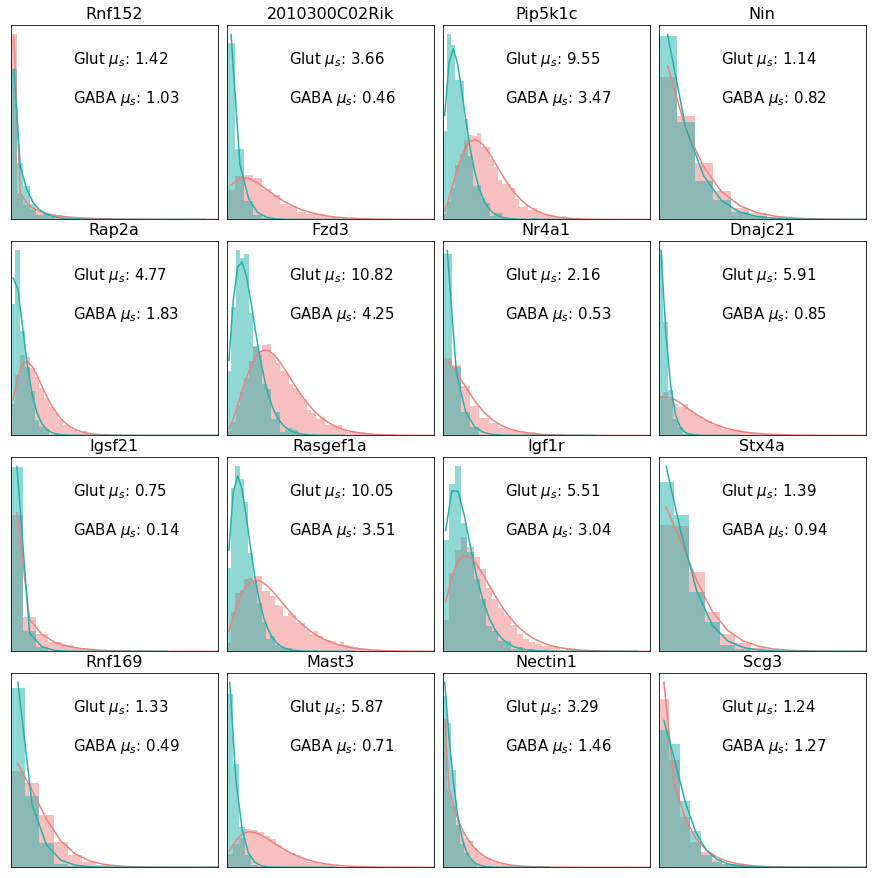

In [1826]:
fig1,ax1=compare_gene_distributions(sr_arr_allen,sd_arr_allen,genes_to_plot=gf_glu_all[0],marg='mature',
                          sz=(4,4),figsize=(12,12))
fig1.savefig('./'+figdir+'/bs_modulation_H12_mature.png',dpi=600)

#### Burst frequency-modulated genes

In [1827]:
np.where(gf_glu_all[1]&gf_glu_all[2])

(array([1235, 2207, 4987]),)

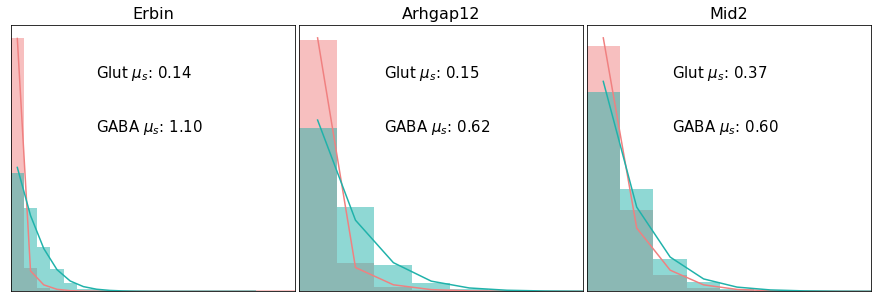

In [1828]:
fig1,ax1=compare_gene_distributions(sr_arr_allen,sd_arr_allen,genes_to_plot=gf_glu_all[1]&gf_glu_all[2],marg='mature',
                          sz=(1,3),figsize=(12,4))

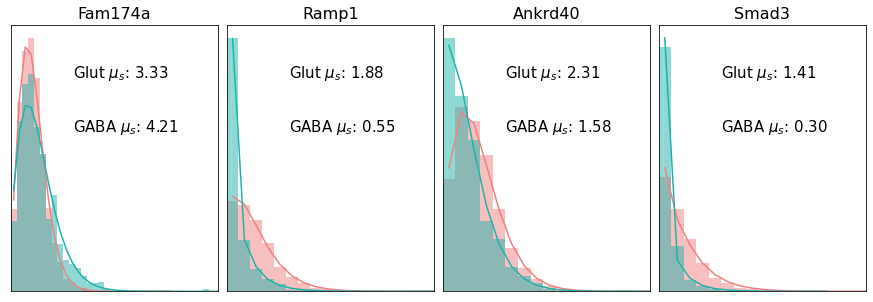

In [1829]:
fig1,ax1=compare_gene_distributions(sr_arr_allen,sd_arr_allen,genes_to_plot=gf_gaba_all[1],marg='mature',
                          sz=(1,4),figsize=(12,4))

In [1830]:
np.sum(gf_gaba_all,1)

array([8, 4, 6])

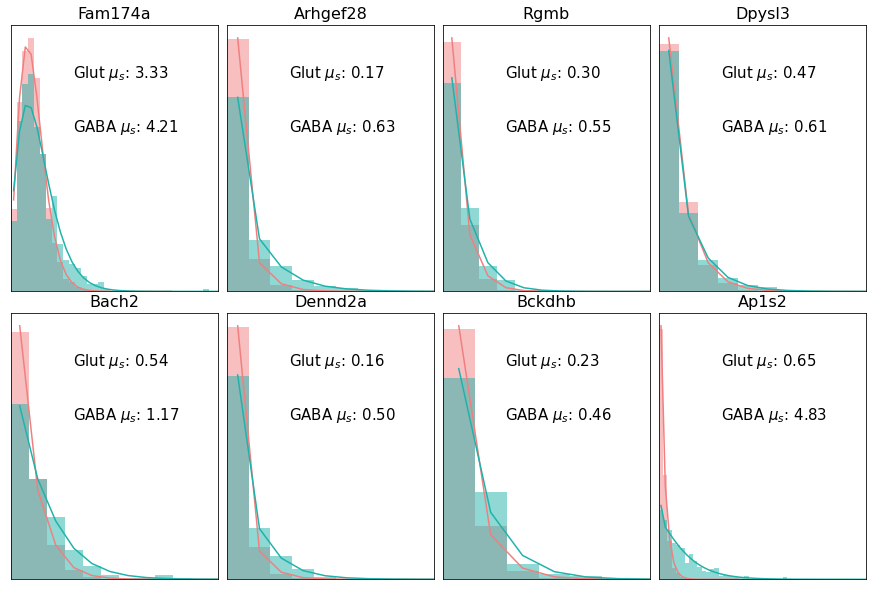

In [1831]:
fig1,ax1=compare_gene_distributions(sr_arr_allen,sd_arr_allen,genes_to_plot=gf_gaba_all[0],marg='mature',
                          sz=(2,4),figsize=(12,8))

#### Low FC genes

In [1848]:
celltype_datasets

['allen_H12_Glutamatergic', 'allen_H12_GABAergic']

In [1832]:
log2_fc_spliced = np.zeros((n_genes,len(allen_celltypes)))
for k,celltype_datasets in enumerate(allen_celltypes):
    sr_arr_allen = [monod.analysis.load_search_results('./fits/'+allen_celltype_batch_dir+'/'+x+'/Bursty_Poisson_1x1/grid_scan_results_upd.res') for x in celltype_datasets]
    sd_arr_allen = [monod.analysis.load_search_data('./fits/'+allen_celltype_batch_dir+'/'+x+'/raw.sd') for x in celltype_datasets]
    log2_fc_spliced[:,k] = np.log2(sd_arr_allen[1].layers[1].mean(1)/sd_arr_allen[0].layers[1].mean(1))
mean_log2_fc_spliced = log2_fc_spliced.mean(1)

/tmp/ipykernel_3463100/3482595576.py:5: RuntimeWarning: divide by zero encountered in log2
  log2_fc_spliced[:,k] = np.log2(sd_arr_allen[1].layers[1].mean(1)/sd_arr_allen[0].layers[1].mean(1))


In [1833]:
bs_modul_low_mean_fc = (gf_gaba_all[0] | gf_glu_all[0]) & (np.abs(mean_log2_fc_spliced)<1)

In [1843]:
for x in gn[bs_modul_low_mean_fc]:
    print(x)

Rnf152
Fam174a
Nin
Rgmb
Dpysl3
Bach2
Igf1r
Stx4a
Scg3


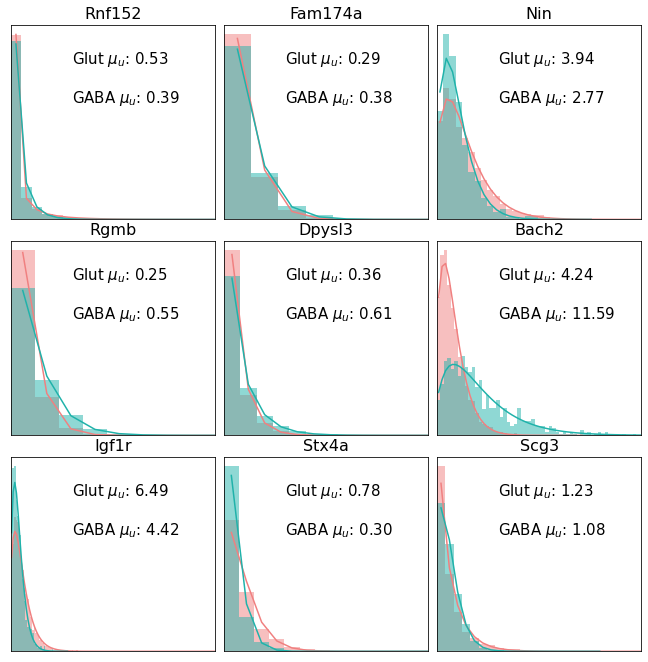

In [1834]:
fig1,ax1=compare_gene_distributions(sr_arr_allen,sd_arr_allen,genes_to_plot=bs_modul_low_mean_fc,marg='nascent',
                          sz=(3,3),figsize=(9,9))
fig1.savefig('./'+figdir+'/bs_modulation_low_mean_fc_H12_nascent.png',dpi=600)

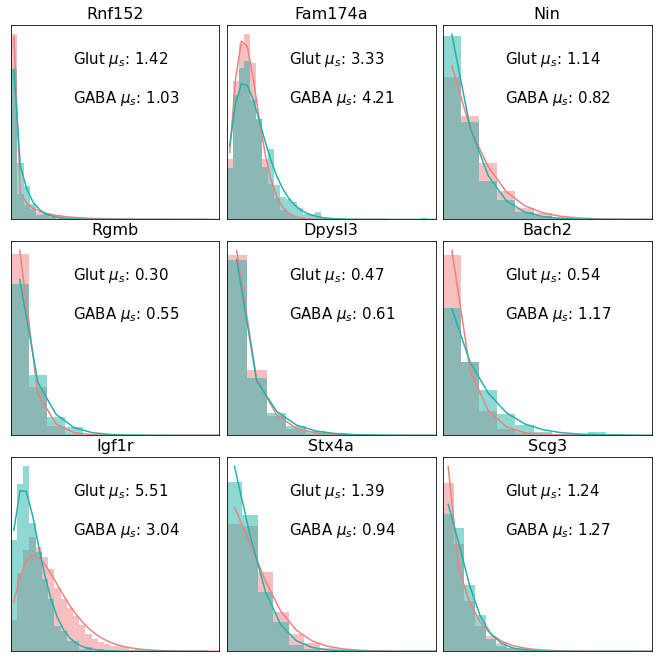

In [1836]:
fig1,ax1=compare_gene_distributions(sr_arr_allen,sd_arr_allen,genes_to_plot=bs_modul_low_mean_fc,marg='mature',
                          sz=(3,3),figsize=(9,9))
fig1.savefig('./'+figdir+'/bs_modulation_low_mean_fc_H12_mature.png',dpi=600)

In [1838]:
k_modul_low_mean_fc = ((np.any(gf_gaba_all[1:],0) | np.any(gf_glu_all[1:],0)) & (np.abs(mean_log2_fc_spliced)<1))

In [1845]:
for x in gn[k_modul_low_mean_fc]:
    print(x)

Fam174a
A330023F24Rik
Socs2
Ankrd40
Slc39a11
Mblac2
Itga4
Cxxc4
Ankrd6
Ccdc136
Crtc3
Egln1
Il34
Mid2


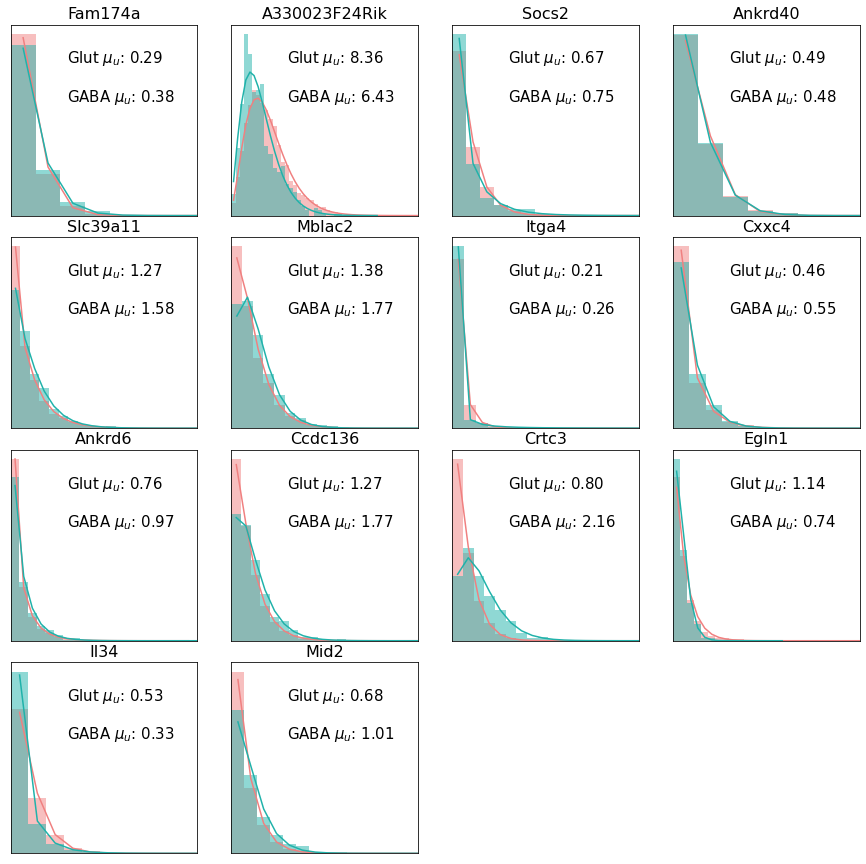

In [1846]:
fig1,ax1=compare_gene_distributions(sr_arr_allen,sd_arr_allen,genes_to_plot=k_modul_low_mean_fc,marg='nascent',
                          sz=(4,4),figsize=(12,12))
plt.delaxes(ax1[3,3])
plt.delaxes(ax1[3,2])

fig1.savefig('./'+figdir+'/k_modulation_low_mean_fc_H12_nascent.png',dpi=600)

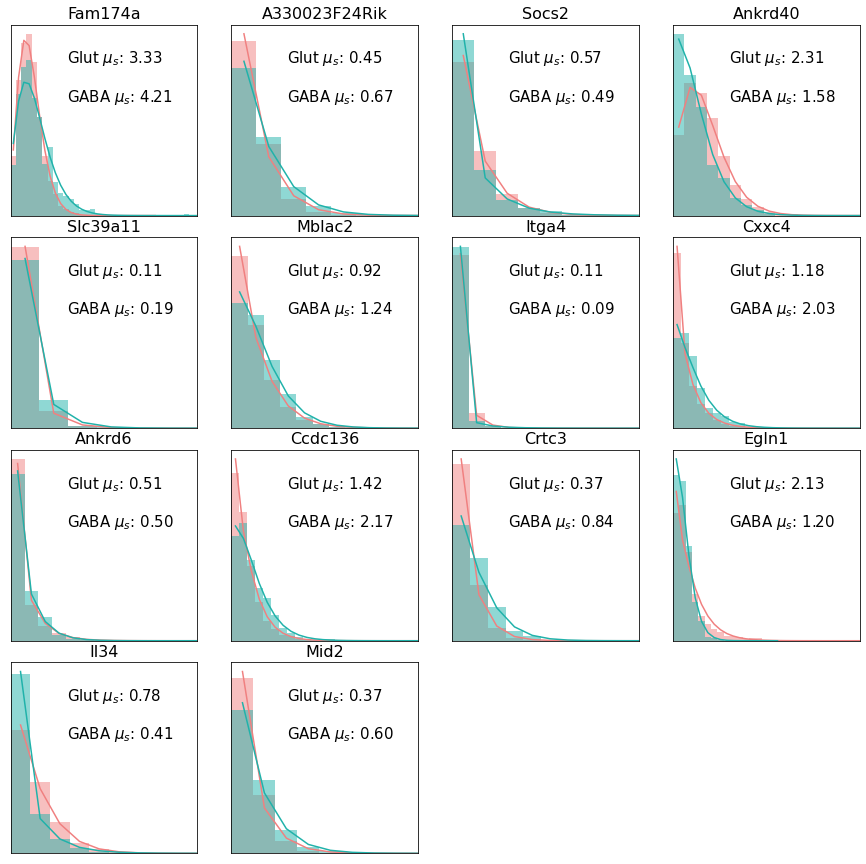

In [1847]:
fig1,ax1=compare_gene_distributions(sr_arr_allen,sd_arr_allen,genes_to_plot=k_modul_low_mean_fc,marg='mature',
                          sz=(4,4),figsize=(12,12))
plt.delaxes(ax1[3,3])
plt.delaxes(ax1[3,2])

fig1.savefig('./'+figdir+'/k_modulation_low_mean_fc_H12_mature.png',dpi=600)

# Other supplementary figures

## Method of moments validation

Here, we test whether the MoM procedure performs sufficiently well to avoid performing many restarts. It appears to be acceptable. 

In [1752]:
MoM_trials

['Bursty_Poisson_10x11_10rest', 'Bursty_Poisson_10x11_1rest']

In [1753]:
sr_arr = [monod.analysis.load_search_results('./fits/'+MoM_batch_dir+'/'+MoM_dataset+'/'+x+'/grid_scan_results.res') for x in MoM_trials]

In [1754]:
q = np.quantile(sr_arr[0].obj_func,0.25)

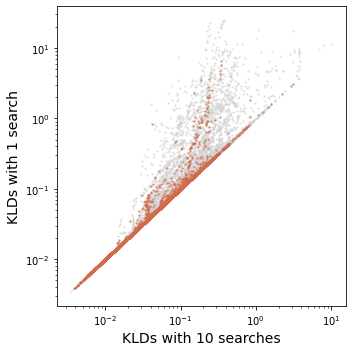

In [1755]:
fig1,ax1 = plt.subplots(1,1,figsize=(5,5))
x = sr_arr[0].klds.flatten()
y = sr_arr[1].klds.flatten()
ax1.scatter(x,y,color=aesthetics['omitted_color'],\
                   s=aesthetics['omitted_markersize_body'],alpha=.5)
x = sr_arr[0].klds[sr_arr[0].obj_func<q].flatten()
y = sr_arr[1].klds[sr_arr[0].obj_func<q].flatten()
ax1.scatter(x,y,color=aesthetics['selected_color'],\
                   s=aesthetics['omitted_markersize_body'],alpha=.5)
ax1.set_xscale('log')
ax1.set_yscale('log')
ax1.set_xlabel('KLDs with 10 searches',fontsize=aesthetics['fontsize_body_axes'])
ax1.set_ylabel('KLDs with 1 search',fontsize=aesthetics['fontsize_body_axes'])
fig1.tight_layout()
fig1.savefig('./'+figdir+'/MoM_control.png',dpi=600)

## Non-length-biased noise

Here, we investigate the parameter trends obtained by running a model with length-independent Poisson technical noise. They are qualitatively similar to the noise-free model results.

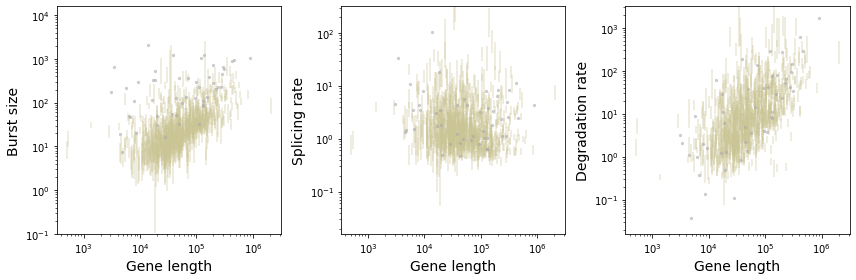

In [1734]:
sr = monod.analysis.load_search_results('./fits/'+ nolength_batch_dir+'/'+nolength_dataset+'/Bursty_Poisson_20x21/grid_scan_results_upd.res')
fig1, ax1 = plt.subplots(nrows=1,ncols=3,figsize=(12,4))
plot_param_length_dependence(sr,ax1[:3])
param_names = ['Burst size','Splicing rate','Degradation rate']
for k in range(3):
    ax1[k].set_ylabel(param_names[k],fontsize=aesthetics['fontsize_body_axes'])
    ax1[k].set_xlabel('Gene length',fontsize=aesthetics['fontsize_body_axes'])
fig1.tight_layout()
fig1.savefig('./'+figdir+'/parameter_length_trends_nolength.png',dpi=600)

In [1735]:
sr.samp_optimum

(-1.605263157894737, -1.025)